In [1]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Sequential 
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPooling2D, LSTM, TimeDistributed, InputLayer, Reshape, BatchNormalization, Bidirectional

2022-11-21 16:17:25.322591: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
import numpy as np
import pandas as pd

def load_dataset(name):
    x = np.load(f'/datasets/nicolas_facchinetti/processed_data/{name}/x_aug.npy')
    y = np.load(f'/datasets/nicolas_facchinetti/processed_data/{name}/y_aug.npy')
    metadata = pd.read_csv(f'/datasets/nicolas_facchinetti/processed_data/{name}/metadata_aug.csv')
    return x, y, metadata

In [3]:
datasets = ["emodb", "emovo", "ravdess"]
data = {}
for d in datasets:
    x, y, md = load_dataset(d)
    data[d] = {}
    data[d]["x"] = x
    data[d]["y"] = y
    data[d]["metadata"] = md

In [4]:
def leave_one_speaker_out(data, n=5):
    speakers = data.actor.unique()
    # random select n actors as test
    selected = np.random.choice(speakers, size=n, replace=False)
    
    myCViterator = []
    for i in selected:
        # take all but not actor i data
        trainIndices = data[~(data['actor']==i)].index.values.astype(int)
        # take only original samples
        testIndices =  data[(data['actor']==i)].index.values.astype(int)
        
        np.random.shuffle(trainIndices)
        np.random.shuffle(testIndices)
        myCViterator.append((trainIndices, testIndices))
    return myCViterator

In [5]:
import matplotlib.pyplot as plt

def plot_res_acc(h, x, y):
    plt.subplot(x, 2, y)
    plt.plot(h.history['accuracy'])
    plt.plot(h.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
def plot_res_loss(h, x, y):
    plt.subplot(x, 2, y)
    plt.plot(h.history['loss'])
    plt.plot(h.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
def plot_stats(h):
    fig = plt.gcf()
    fig.set_size_inches(15, 15)
    for num, c in enumerate(h):
        n = (num+1)*2
        plot_res_acc(c, len(h), n-1)
        plot_res_loss(c, len(h), n)
    plt.show()

In [6]:
def train_avaluate(model_fn, kf, x, y):
    cv_acc = []
    for train_index, val_index in kf:
        m = model_fn()
        m.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')
        # fit & predict
        history = m.fit(x[train_index], y[train_index],
                        batch_size=64,
                        epochs=30,
                        validation_data=(x[val_index], y[val_index]),
                        verbose=1)
        print("Done")
        cv_acc.append(history)
    return cv_acc

# Models

In [7]:
def get_m1():
    m = Sequential([
            InputLayer(input_shape=(256,256,3)),
            Reshape((16,16,256,3)),
            TimeDistributed(Conv2D(16, kernel_size=(3,3), activation='relu')),
            TimeDistributed(BatchNormalization()),
            TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=2)),

            TimeDistributed(Conv2D(32, kernel_size=(3,3), activation='relu')),
            TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=1)),

            TimeDistributed(Conv2D(64, kernel_size=(3,3), activation='relu')),
            TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=1)),
            TimeDistributed(Flatten()),

            Bidirectional(LSTM(4, return_sequences=False)),
            Dropout(0.6),
            Dense(7, activation='softmax')
    ])
    return m

get_m1().summary()

2022-11-19 08:46:14.192951: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-11-19 08:46:14.194525: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-11-19 08:46:14.317074: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:15:00.0 name: NVIDIA TITAN V computeCapability: 7.0
coreClock: 1.455GHz coreCount: 80 deviceMemorySize: 11.78GiB deviceMemoryBandwidth: 607.97GiB/s
2022-11-19 08:46:14.317109: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-11-19 08:46:14.379914: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-11-19 08:46:14.380069: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2022-1

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 16, 16, 256, 3)    0         
_________________________________________________________________
time_distributed (TimeDistri (None, 16, 14, 254, 16)   448       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 16, 14, 254, 16)   64        
_________________________________________________________________
time_distributed_2 (TimeDist (None, 16, 7, 127, 16)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 16, 5, 125, 32)    4640      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 16, 4, 124, 32)    0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 16, 2, 122, 64)    1

In [8]:
def get_m2():
    m = Sequential([
            InputLayer(input_shape=(256,256,3)),
            Reshape((16,16,256,3)),
            TimeDistributed(Conv2D(16, kernel_size=(3,3), activation='relu')),
            TimeDistributed(BatchNormalization()),
            TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=2)),

            TimeDistributed(Conv2D(32, kernel_size=(3,3), activation='relu')),
            TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=1)),

            TimeDistributed(Conv2D(64, kernel_size=(3,3), activation='relu')),
            TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=1)),
            TimeDistributed(Flatten()),

            Bidirectional(LSTM(8, return_sequences=False)),
            Dropout(0.6),
            Dense(7, activation='softmax')
        ])
    return m

get_m2().summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 16, 16, 256, 3)    0         
_________________________________________________________________
time_distributed_8 (TimeDist (None, 16, 14, 254, 16)   448       
_________________________________________________________________
time_distributed_9 (TimeDist (None, 16, 14, 254, 16)   64        
_________________________________________________________________
time_distributed_10 (TimeDis (None, 16, 7, 127, 16)    0         
_________________________________________________________________
time_distributed_11 (TimeDis (None, 16, 5, 125, 32)    4640      
_________________________________________________________________
time_distributed_12 (TimeDis (None, 16, 4, 124, 32)    0         
_________________________________________________________________
time_distributed_13 (TimeDis (None, 16, 2, 122, 64)   

In [9]:
def get_m3():
    m = Sequential([
            InputLayer(input_shape=(256,256,3)),
            Reshape((16,16,256,3)),
            TimeDistributed(Conv2D(16, kernel_size=(5,5), activation='relu')),
            TimeDistributed(BatchNormalization()),
            TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=1)),

            TimeDistributed(Conv2D(32, kernel_size=(3,3), activation='relu')),
            TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=1)),

            TimeDistributed(Conv2D(64, kernel_size=(3,3), activation='relu')),
            TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=1)),
        
            TimeDistributed(Conv2D(128, kernel_size=(3,3), activation='relu')),
            TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=1)),
            TimeDistributed(Flatten()),

            LSTM(4, return_sequences=False),
            Dropout(0.6),
            Dense(7, activation='softmax')
    ])
    return m

get_m3().summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 16, 16, 256, 3)    0         
_________________________________________________________________
time_distributed_16 (TimeDis (None, 16, 12, 252, 16)   1216      
_________________________________________________________________
time_distributed_17 (TimeDis (None, 16, 12, 252, 16)   64        
_________________________________________________________________
time_distributed_18 (TimeDis (None, 16, 11, 251, 16)   0         
_________________________________________________________________
time_distributed_19 (TimeDis (None, 16, 9, 249, 32)    4640      
_________________________________________________________________
time_distributed_20 (TimeDis (None, 16, 8, 248, 32)    0         
_________________________________________________________________
time_distributed_21 (TimeDis (None, 16, 6, 246, 64)   

In [10]:
def get_m4():
    m = Sequential([
            InputLayer(input_shape=(256,256,3)),
            Reshape((16,16,256,3)),
            TimeDistributed(Conv2D(16, kernel_size=(7,7), activation='relu')),
            TimeDistributed(BatchNormalization()),
            TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=1)),

            TimeDistributed(Conv2D(32, kernel_size=(5,5), activation='relu')),
            TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=1)),

            TimeDistributed(Conv2D(64, kernel_size=(3,3), activation='relu')),
            TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=1)),
            TimeDistributed(Flatten()),

            LSTM(4, return_sequences=False),
            Dropout(0.6),
            Dense(7, activation='softmax')
    ])
    return m

get_m4().summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, 16, 16, 256, 3)    0         
_________________________________________________________________
time_distributed_26 (TimeDis (None, 16, 10, 250, 16)   2368      
_________________________________________________________________
time_distributed_27 (TimeDis (None, 16, 10, 250, 16)   64        
_________________________________________________________________
time_distributed_28 (TimeDis (None, 16, 9, 249, 16)    0         
_________________________________________________________________
time_distributed_29 (TimeDis (None, 16, 5, 245, 32)    12832     
_________________________________________________________________
time_distributed_30 (TimeDis (None, 16, 4, 244, 32)    0         
_________________________________________________________________
time_distributed_31 (TimeDis (None, 16, 2, 242, 64)   

In [11]:
def get_m5():
    m = Sequential([
            InputLayer(input_shape=(256,256,3)),
            Reshape((8,32,256,3)),
            TimeDistributed(Conv2D(16, kernel_size=(5,5), activation='relu')),
            TimeDistributed(BatchNormalization()),
            TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=2)),

            TimeDistributed(Conv2D(32, kernel_size=(5,5), activation='relu')),
            TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=1)),

            TimeDistributed(Conv2D(64, kernel_size=(3,3), activation='relu')),
            TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=1)),
        
            TimeDistributed(Conv2D(128, kernel_size=(3,3), activation='relu')),
            TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=1)),
            TimeDistributed(Flatten()),

            LSTM(3, return_sequences=False),
            Dropout(0.6),
            Dense(7, activation='softmax')
    ])
    return m

get_m5().summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_4 (Reshape)          (None, 8, 32, 256, 3)     0         
_________________________________________________________________
time_distributed_34 (TimeDis (None, 8, 28, 252, 16)    1216      
_________________________________________________________________
time_distributed_35 (TimeDis (None, 8, 28, 252, 16)    64        
_________________________________________________________________
time_distributed_36 (TimeDis (None, 8, 14, 126, 16)    0         
_________________________________________________________________
time_distributed_37 (TimeDis (None, 8, 10, 122, 32)    12832     
_________________________________________________________________
time_distributed_38 (TimeDis (None, 8, 9, 121, 32)     0         
_________________________________________________________________
time_distributed_39 (TimeDis (None, 8, 7, 119, 64)    

In [12]:
def get_m6():
    m = Sequential([
            InputLayer(input_shape=(256,256,3)),
            Reshape((8,32,256,3)),
            TimeDistributed(Conv2D(16, kernel_size=(5,5), activation='relu')),
            TimeDistributed(BatchNormalization()),
            TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=2)),

            TimeDistributed(Conv2D(32, kernel_size=(5,5), activation='relu')),
            TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=1)),

            TimeDistributed(Conv2D(64, kernel_size=(3,3), activation='relu')),
            TimeDistributed(Conv2D(64, kernel_size=(3,3), activation='relu')),
            TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=1)),
        
            TimeDistributed(Flatten()),

            Bidirectional(LSTM(3, return_sequences=False)),
            Dropout(0.6),
            Dense(7, activation='softmax')
    ])
    return m

get_m6().summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_5 (Reshape)          (None, 8, 32, 256, 3)     0         
_________________________________________________________________
time_distributed_44 (TimeDis (None, 8, 28, 252, 16)    1216      
_________________________________________________________________
time_distributed_45 (TimeDis (None, 8, 28, 252, 16)    64        
_________________________________________________________________
time_distributed_46 (TimeDis (None, 8, 14, 126, 16)    0         
_________________________________________________________________
time_distributed_47 (TimeDis (None, 8, 10, 122, 32)    12832     
_________________________________________________________________
time_distributed_48 (TimeDis (None, 8, 9, 121, 32)     0         
_________________________________________________________________
time_distributed_49 (TimeDis (None, 8, 7, 119, 64)    

# EmoDB

In [189]:
kf1 = leave_one_speaker_out(data["emodb"]["metadata"], n=3)         

In [190]:
ac1_1 = train_avaluate(get_m1, kf1, data["emodb"]["x"], data["emodb"]["y"] )

Epoch 1/30
87/87 [==============================] - 15s 71ms/step - loss: 1.9333 - accuracy: 0.2210 - val_loss: 1.9100 - val_accuracy: 0.2055
Epoch 2/30
87/87 [==============================] - 6s 65ms/step - loss: 1.8862 - accuracy: 0.2316 - val_loss: 1.8944 - val_accuracy: 0.2192
Epoch 3/30
87/87 [==============================] - 6s 65ms/step - loss: 1.8482 - accuracy: 0.2447 - val_loss: 1.7258 - val_accuracy: 0.3699
Epoch 4/30
87/87 [==============================] - 6s 65ms/step - loss: 1.7772 - accuracy: 0.2962 - val_loss: 1.7268 - val_accuracy: 0.3425
Epoch 5/30
87/87 [==============================] - 6s 65ms/step - loss: 1.6753 - accuracy: 0.3713 - val_loss: 1.5529 - val_accuracy: 0.3836
Epoch 6/30
87/87 [==============================] - 6s 65ms/step - loss: 1.6605 - accuracy: 0.3816 - val_loss: 1.5049 - val_accuracy: 0.4247
Epoch 7/30
87/87 [==============================] - 6s 65ms/step - loss: 1.6320 - accuracy: 0.3872 - val_loss: 1.5164 - val_accuracy: 0.4110
Epoch 8/30
8

Epoch 29/30
89/89 [==============================] - 6s 65ms/step - loss: 0.7871 - accuracy: 0.6559 - val_loss: 1.2143 - val_accuracy: 0.5789
Epoch 30/30
89/89 [==============================] - 6s 66ms/step - loss: 0.8026 - accuracy: 0.6357 - val_loss: 1.4014 - val_accuracy: 0.4561
Done
Epoch 1/30
84/84 [==============================] - 8s 70ms/step - loss: 1.9385 - accuracy: 0.2069 - val_loss: 1.9124 - val_accuracy: 0.2247
Epoch 2/30
84/84 [==============================] - 5s 65ms/step - loss: 1.8848 - accuracy: 0.2706 - val_loss: 1.8870 - val_accuracy: 0.3146
Epoch 3/30
84/84 [==============================] - 5s 64ms/step - loss: 1.8381 - accuracy: 0.3094 - val_loss: 1.7044 - val_accuracy: 0.3820
Epoch 4/30
84/84 [==============================] - 5s 65ms/step - loss: 1.7572 - accuracy: 0.3351 - val_loss: 1.6298 - val_accuracy: 0.4270
Epoch 5/30
84/84 [==============================] - 5s 65ms/step - loss: 1.7350 - accuracy: 0.3211 - val_loss: 1.5653 - val_accuracy: 0.4045
Epoch 

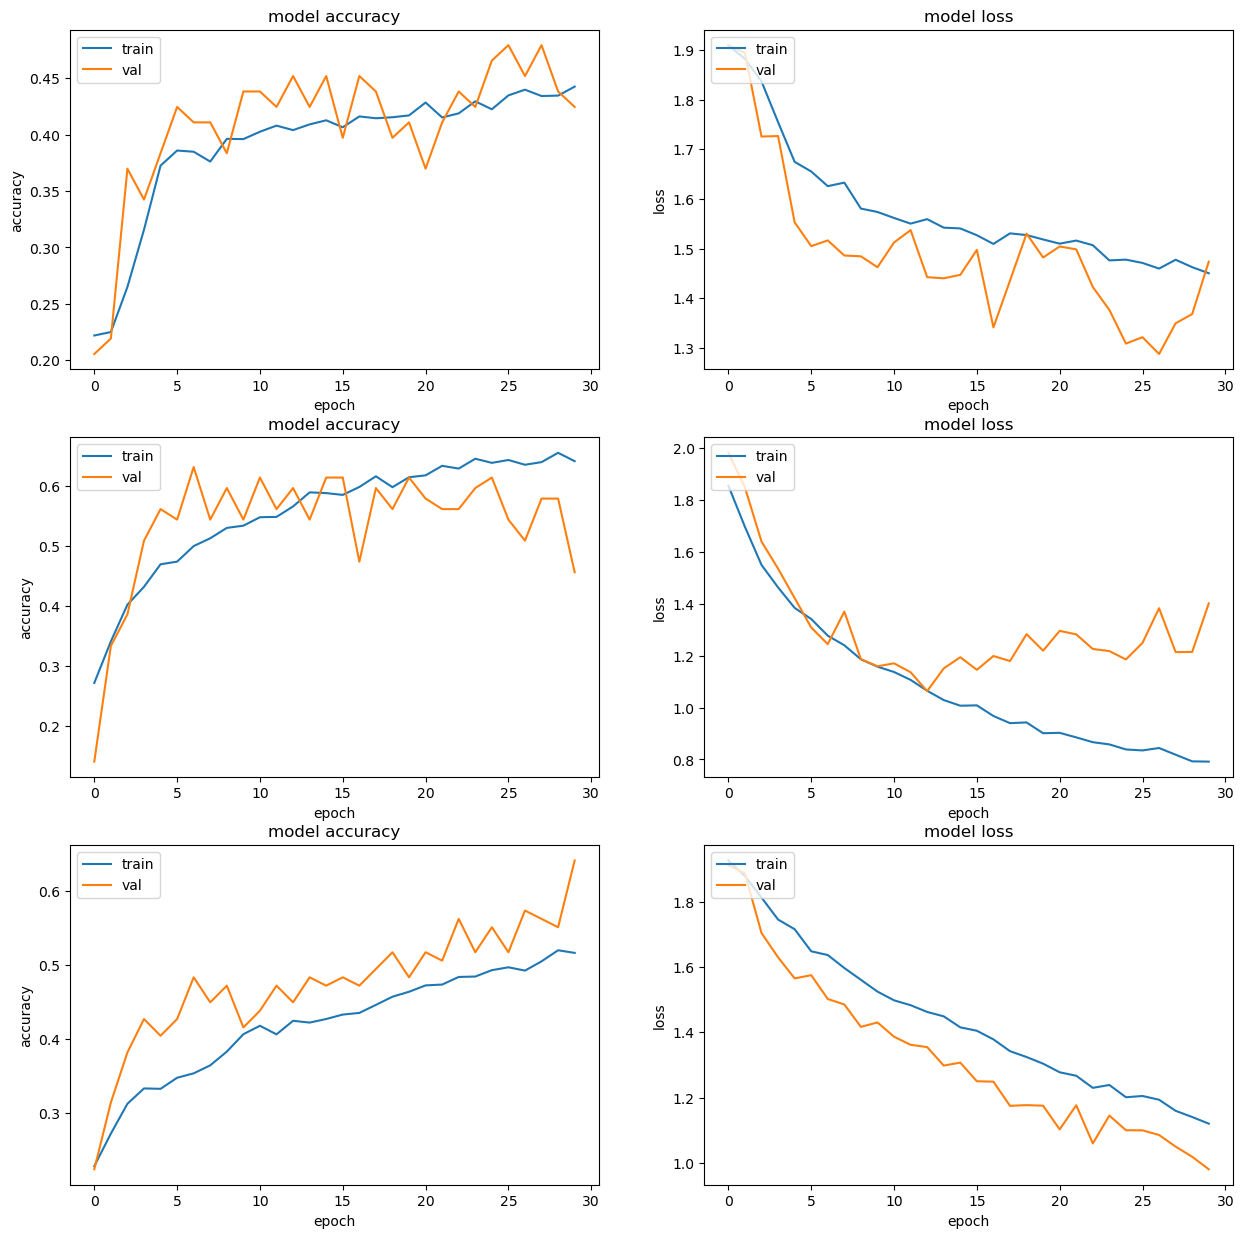

In [191]:
plot_stats(ac1_1)

In [192]:
ac1_2 = train_avaluate(get_m2, kf1, data["emodb"]["x"], data["emodb"]["y"] )

Epoch 1/30
87/87 [==============================] - 8s 70ms/step - loss: 1.9085 - accuracy: 0.2494 - val_loss: 1.8281 - val_accuracy: 0.3288
Epoch 2/30
87/87 [==============================] - 6s 64ms/step - loss: 1.7449 - accuracy: 0.3472 - val_loss: 1.6188 - val_accuracy: 0.3699
Epoch 3/30
87/87 [==============================] - 6s 65ms/step - loss: 1.6232 - accuracy: 0.3889 - val_loss: 1.5219 - val_accuracy: 0.3699
Epoch 4/30
87/87 [==============================] - 6s 64ms/step - loss: 1.5367 - accuracy: 0.4277 - val_loss: 1.4085 - val_accuracy: 0.4658
Epoch 5/30
87/87 [==============================] - 6s 65ms/step - loss: 1.4918 - accuracy: 0.4295 - val_loss: 1.4707 - val_accuracy: 0.3973
Epoch 6/30
87/87 [==============================] - 6s 65ms/step - loss: 1.4203 - accuracy: 0.4482 - val_loss: 1.3633 - val_accuracy: 0.4247
Epoch 7/30
87/87 [==============================] - 6s 64ms/step - loss: 1.3832 - accuracy: 0.4657 - val_loss: 1.3060 - val_accuracy: 0.4384
Epoch 8/30
87

Epoch 29/30
89/89 [==============================] - 6s 64ms/step - loss: 0.5543 - accuracy: 0.7761 - val_loss: 1.2559 - val_accuracy: 0.5439
Epoch 30/30
89/89 [==============================] - 6s 64ms/step - loss: 0.5652 - accuracy: 0.7765 - val_loss: 1.1951 - val_accuracy: 0.5439
Done
Epoch 1/30
84/84 [==============================] - 8s 70ms/step - loss: 1.8815 - accuracy: 0.2354 - val_loss: 1.7616 - val_accuracy: 0.4831
Epoch 2/30
84/84 [==============================] - 5s 65ms/step - loss: 1.6914 - accuracy: 0.3658 - val_loss: 1.5485 - val_accuracy: 0.4719
Epoch 3/30
84/84 [==============================] - 6s 66ms/step - loss: 1.5565 - accuracy: 0.4097 - val_loss: 1.4244 - val_accuracy: 0.4719
Epoch 4/30
84/84 [==============================] - 5s 65ms/step - loss: 1.4949 - accuracy: 0.4431 - val_loss: 1.3016 - val_accuracy: 0.4719
Epoch 5/30
84/84 [==============================] - 5s 64ms/step - loss: 1.4330 - accuracy: 0.4593 - val_loss: 1.3305 - val_accuracy: 0.4382
Epoch 

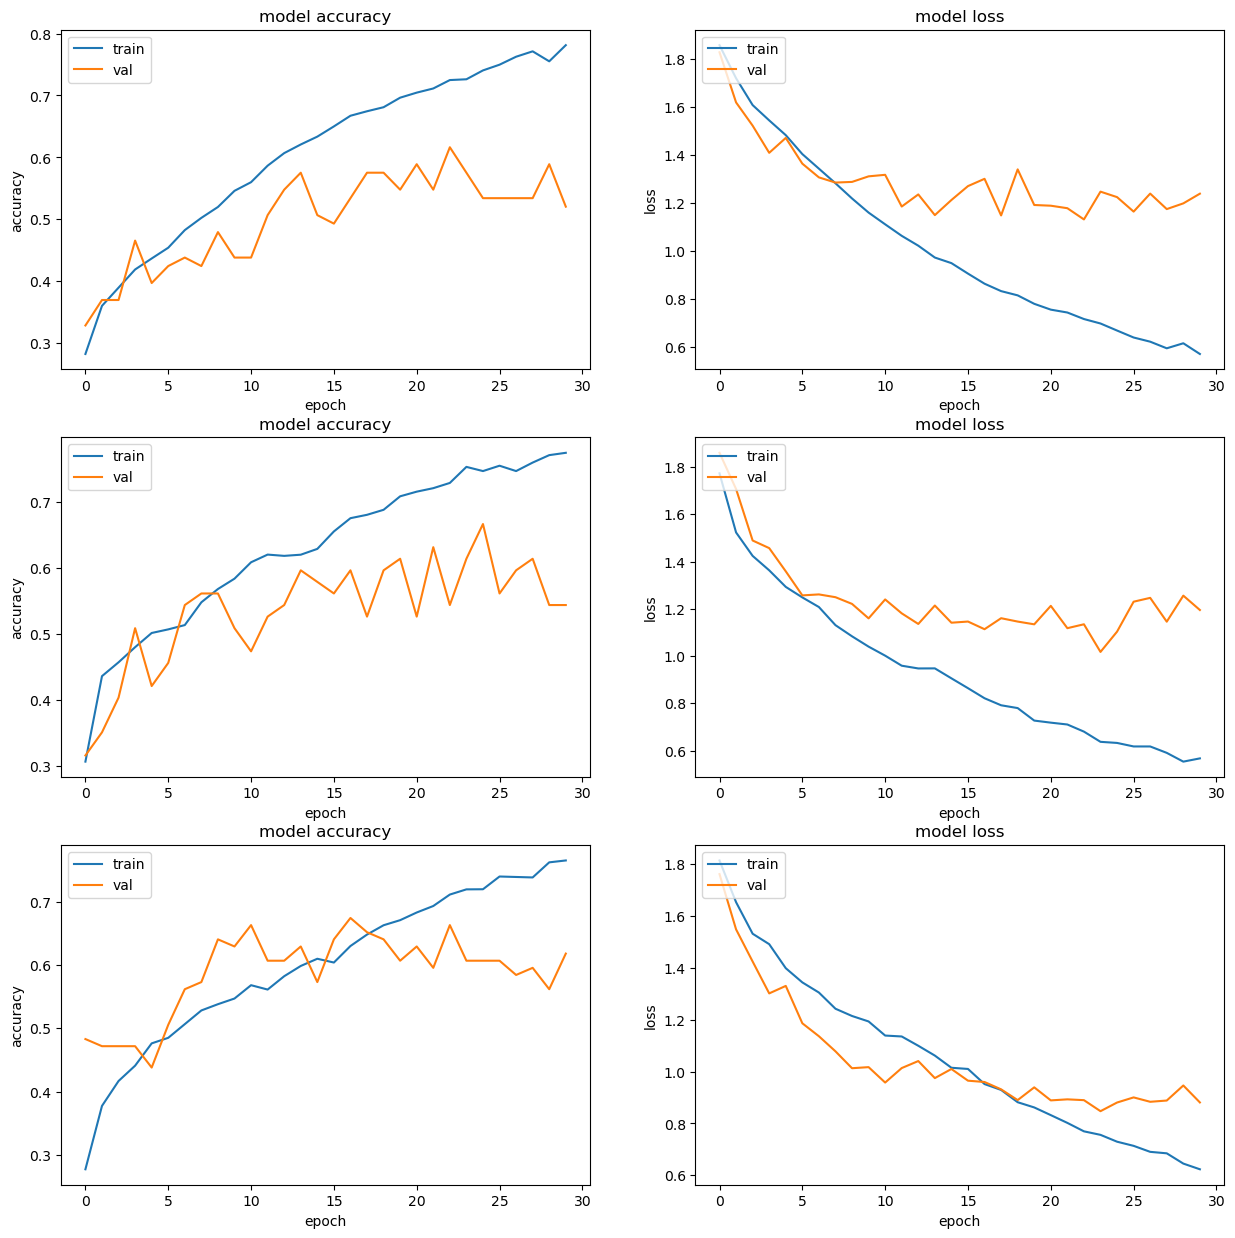

In [193]:
plot_stats(ac1_2)

In [194]:
ac1_3 = train_avaluate(get_m3, kf1, data["emodb"]["x"], data["emodb"]["y"] )

Epoch 1/30
87/87 [==============================] - 13s 138ms/step - loss: 1.9431 - accuracy: 0.2153 - val_loss: 1.9529 - val_accuracy: 0.1644
Epoch 2/30
87/87 [==============================] - 11s 130ms/step - loss: 1.8981 - accuracy: 0.2799 - val_loss: 1.8768 - val_accuracy: 0.2466
Epoch 3/30
87/87 [==============================] - 11s 131ms/step - loss: 1.8882 - accuracy: 0.2576 - val_loss: 1.8900 - val_accuracy: 0.2603
Epoch 4/30
87/87 [==============================] - 11s 131ms/step - loss: 1.8786 - accuracy: 0.2613 - val_loss: 1.8778 - val_accuracy: 0.2877
Epoch 5/30
87/87 [==============================] - 11s 131ms/step - loss: 1.8733 - accuracy: 0.2604 - val_loss: 1.8649 - val_accuracy: 0.2877
Epoch 6/30
87/87 [==============================] - 11s 131ms/step - loss: 1.8567 - accuracy: 0.2728 - val_loss: 1.8514 - val_accuracy: 0.2740
Epoch 7/30
87/87 [==============================] - 11s 130ms/step - loss: 1.8555 - accuracy: 0.2636 - val_loss: 1.8510 - val_accuracy: 0.2877

Epoch 28/30
89/89 [==============================] - 12s 131ms/step - loss: 1.9167 - accuracy: 0.2097 - val_loss: 1.9540 - val_accuracy: 0.2632
Epoch 29/30
89/89 [==============================] - 12s 132ms/step - loss: 1.9092 - accuracy: 0.2195 - val_loss: 1.9545 - val_accuracy: 0.2632
Epoch 30/30
89/89 [==============================] - 12s 131ms/step - loss: 1.9059 - accuracy: 0.2185 - val_loss: 1.9552 - val_accuracy: 0.2632
Done
Epoch 1/30
84/84 [==============================] - 13s 145ms/step - loss: 1.9499 - accuracy: 0.1934 - val_loss: 1.9402 - val_accuracy: 0.2135
Epoch 2/30
84/84 [==============================] - 11s 131ms/step - loss: 1.9313 - accuracy: 0.2267 - val_loss: 1.9370 - val_accuracy: 0.2135
Epoch 3/30
84/84 [==============================] - 11s 131ms/step - loss: 1.9246 - accuracy: 0.2177 - val_loss: 1.9359 - val_accuracy: 0.2135
Epoch 4/30
84/84 [==============================] - 11s 131ms/step - loss: 1.9206 - accuracy: 0.2203 - val_loss: 1.9357 - val_accuracy

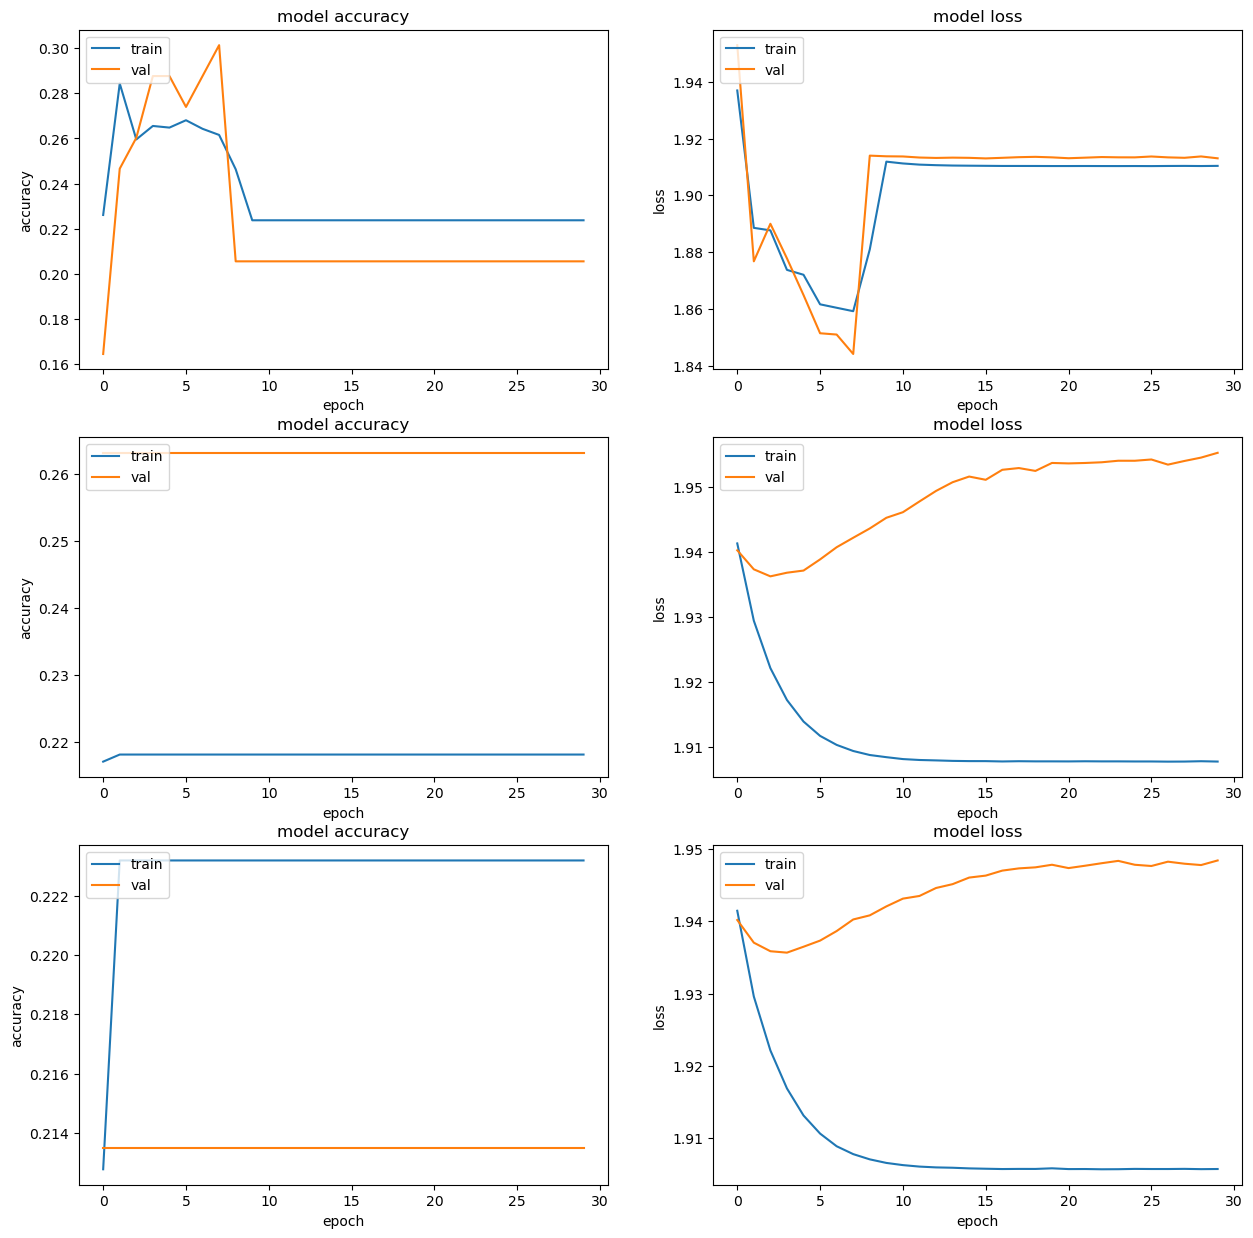

In [195]:
plot_stats(ac1_3)

In [196]:
ac1_4 = train_avaluate(get_m4, kf1, data["emodb"]["x"], data["emodb"]["y"] )

Epoch 1/30
87/87 [==============================] - 11s 112ms/step - loss: 1.9413 - accuracy: 0.1962 - val_loss: 1.9352 - val_accuracy: 0.2055
Epoch 2/30
87/87 [==============================] - 6s 70ms/step - loss: 1.9323 - accuracy: 0.2215 - val_loss: 1.9280 - val_accuracy: 0.2055
Epoch 3/30
87/87 [==============================] - 6s 71ms/step - loss: 1.9244 - accuracy: 0.2271 - val_loss: 1.9229 - val_accuracy: 0.2055
Epoch 4/30
87/87 [==============================] - 6s 71ms/step - loss: 1.9178 - accuracy: 0.2268 - val_loss: 1.9194 - val_accuracy: 0.2055
Epoch 5/30
87/87 [==============================] - 6s 70ms/step - loss: 1.9134 - accuracy: 0.2269 - val_loss: 1.9177 - val_accuracy: 0.2055
Epoch 6/30
87/87 [==============================] - 6s 70ms/step - loss: 1.9096 - accuracy: 0.2341 - val_loss: 1.9164 - val_accuracy: 0.2055
Epoch 7/30
87/87 [==============================] - 6s 71ms/step - loss: 1.9087 - accuracy: 0.2362 - val_loss: 1.9154 - val_accuracy: 0.2055
Epoch 8/30


Epoch 29/30
89/89 [==============================] - 6s 71ms/step - loss: 1.2359 - accuracy: 0.4545 - val_loss: 1.1553 - val_accuracy: 0.5088
Epoch 30/30
89/89 [==============================] - 6s 70ms/step - loss: 1.2386 - accuracy: 0.4508 - val_loss: 1.2007 - val_accuracy: 0.5088
Done
Epoch 1/30
84/84 [==============================] - 8s 81ms/step - loss: 1.9451 - accuracy: 0.2102 - val_loss: 1.9403 - val_accuracy: 0.2135
Epoch 2/30
84/84 [==============================] - 6s 71ms/step - loss: 1.9302 - accuracy: 0.2272 - val_loss: 1.9375 - val_accuracy: 0.2135
Epoch 3/30
84/84 [==============================] - 6s 70ms/step - loss: 1.9223 - accuracy: 0.2261 - val_loss: 1.9358 - val_accuracy: 0.2135
Epoch 4/30
84/84 [==============================] - 6s 71ms/step - loss: 1.9171 - accuracy: 0.2284 - val_loss: 1.9355 - val_accuracy: 0.2135
Epoch 5/30
84/84 [==============================] - 6s 70ms/step - loss: 1.9120 - accuracy: 0.2267 - val_loss: 1.9362 - val_accuracy: 0.2135
Epoch 

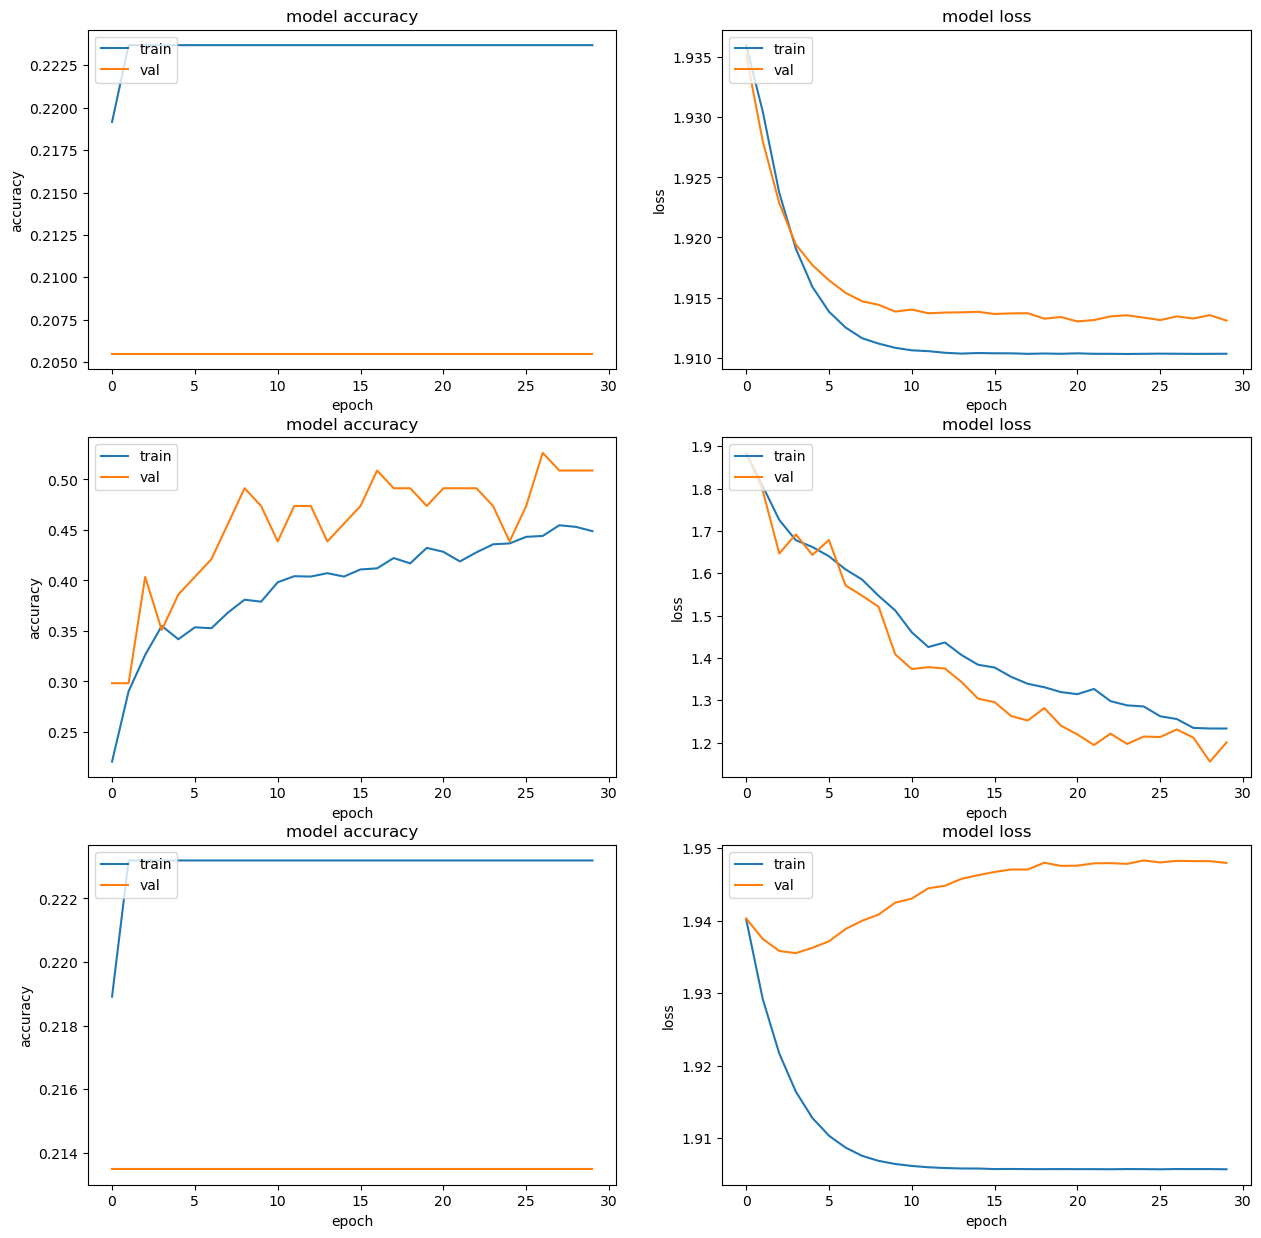

In [197]:
plot_stats(ac1_4)

In [198]:
ac1_5 = train_avaluate(get_m5, kf1, data["emodb"]["x"], data["emodb"]["y"] )

Epoch 1/30
87/87 [==============================] - 8s 75ms/step - loss: 1.9473 - accuracy: 0.2128 - val_loss: 1.9352 - val_accuracy: 0.2055
Epoch 2/30
87/87 [==============================] - 6s 67ms/step - loss: 1.9323 - accuracy: 0.2244 - val_loss: 1.9273 - val_accuracy: 0.2055
Epoch 3/30
87/87 [==============================] - 6s 68ms/step - loss: 1.9267 - accuracy: 0.2214 - val_loss: 1.9221 - val_accuracy: 0.2055
Epoch 4/30
87/87 [==============================] - 6s 68ms/step - loss: 1.9186 - accuracy: 0.2259 - val_loss: 1.9191 - val_accuracy: 0.2055
Epoch 5/30
87/87 [==============================] - 6s 68ms/step - loss: 1.9158 - accuracy: 0.2220 - val_loss: 1.9168 - val_accuracy: 0.2055
Epoch 6/30
87/87 [==============================] - 6s 67ms/step - loss: 1.9192 - accuracy: 0.2172 - val_loss: 1.9158 - val_accuracy: 0.2055
Epoch 7/30
87/87 [==============================] - 6s 68ms/step - loss: 1.9141 - accuracy: 0.2153 - val_loss: 1.9147 - val_accuracy: 0.2055
Epoch 8/30
87

Epoch 29/30
89/89 [==============================] - 6s 68ms/step - loss: 1.9073 - accuracy: 0.2164 - val_loss: 1.9547 - val_accuracy: 0.2632
Epoch 30/30
89/89 [==============================] - 6s 66ms/step - loss: 1.9126 - accuracy: 0.2092 - val_loss: 1.9543 - val_accuracy: 0.2632
Done
Epoch 1/30
84/84 [==============================] - 8s 78ms/step - loss: 1.9911 - accuracy: 0.1837 - val_loss: 1.9280 - val_accuracy: 0.2135
Epoch 2/30
84/84 [==============================] - 6s 68ms/step - loss: 1.9725 - accuracy: 0.2271 - val_loss: 1.9383 - val_accuracy: 0.2135
Epoch 3/30
84/84 [==============================] - 6s 68ms/step - loss: 1.9177 - accuracy: 0.2295 - val_loss: 1.9315 - val_accuracy: 0.2135
Epoch 4/30
84/84 [==============================] - 6s 68ms/step - loss: 1.9130 - accuracy: 0.2258 - val_loss: 1.9467 - val_accuracy: 0.2247
Epoch 5/30
84/84 [==============================] - 6s 68ms/step - loss: 1.9047 - accuracy: 0.2248 - val_loss: 1.9393 - val_accuracy: 0.2247
Epoch 

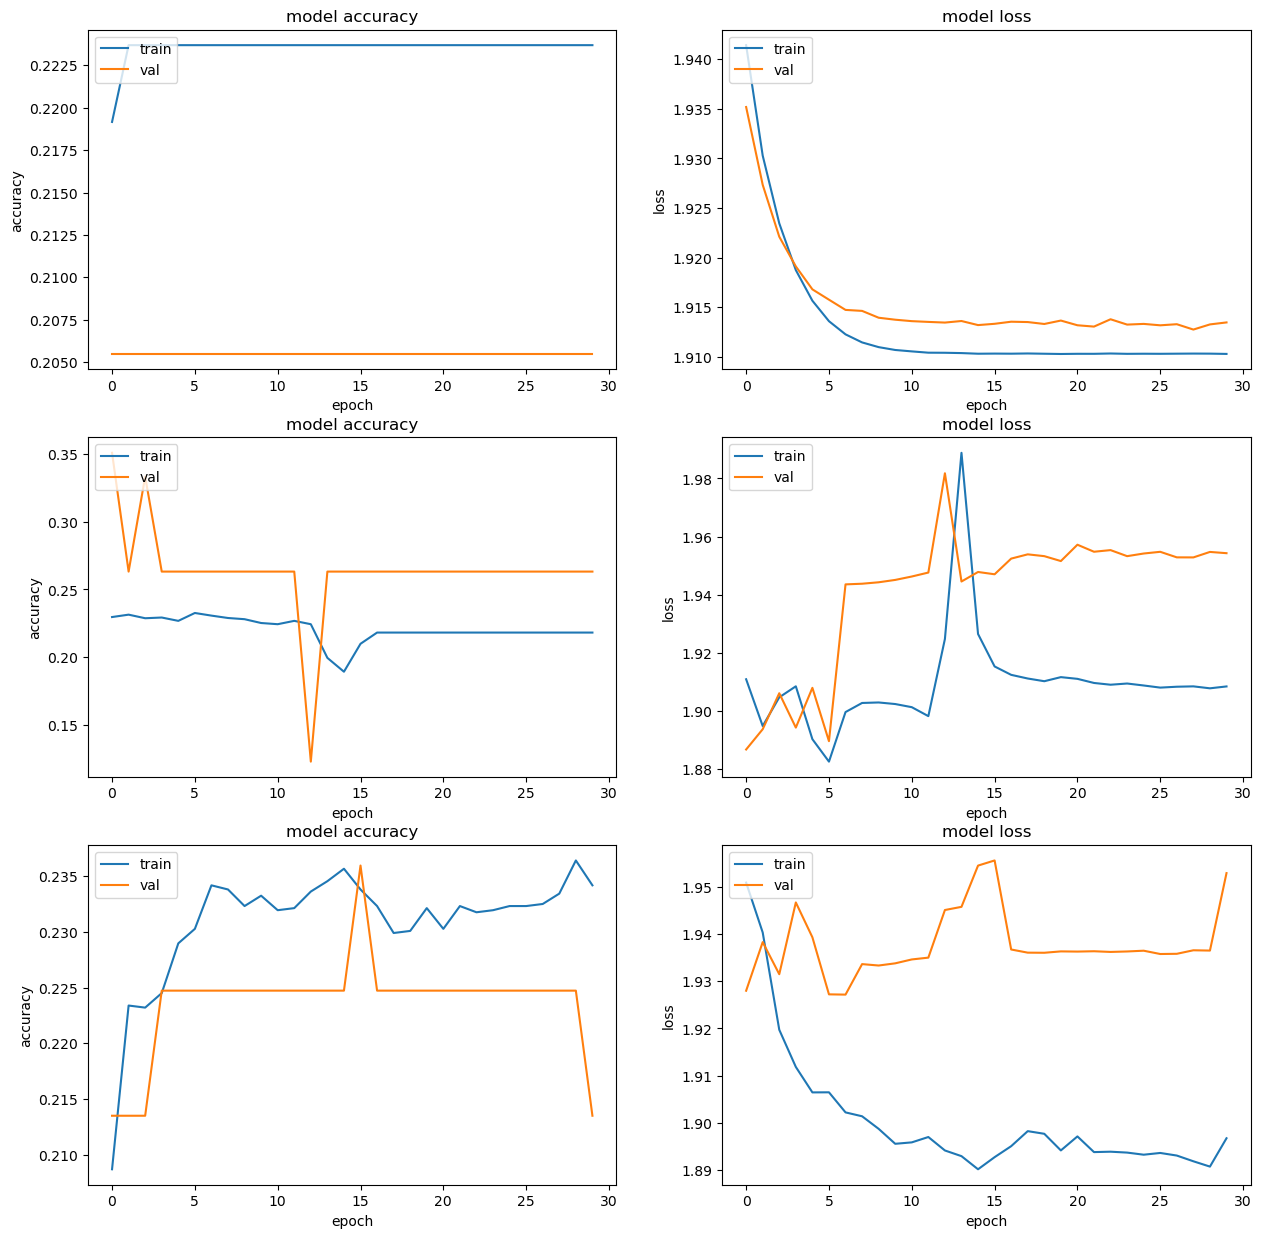

In [199]:
plot_stats(ac1_5)

In [200]:
ac1_6 = train_avaluate(get_m6, kf1, data["emodb"]["x"], data["emodb"]["y"] )

Epoch 1/30
87/87 [==============================] - 8s 77ms/step - loss: 1.9701 - accuracy: 0.1896 - val_loss: 1.9349 - val_accuracy: 0.2055
Epoch 2/30
87/87 [==============================] - 6s 70ms/step - loss: 1.9320 - accuracy: 0.2252 - val_loss: 1.9272 - val_accuracy: 0.2055
Epoch 3/30
87/87 [==============================] - 6s 70ms/step - loss: 1.9243 - accuracy: 0.2241 - val_loss: 1.9220 - val_accuracy: 0.2055
Epoch 4/30
87/87 [==============================] - 6s 71ms/step - loss: 1.9190 - accuracy: 0.2211 - val_loss: 1.9189 - val_accuracy: 0.2055
Epoch 5/30
87/87 [==============================] - 6s 71ms/step - loss: 1.9162 - accuracy: 0.2220 - val_loss: 1.9167 - val_accuracy: 0.2055
Epoch 6/30
87/87 [==============================] - 6s 70ms/step - loss: 1.9179 - accuracy: 0.2181 - val_loss: 1.9158 - val_accuracy: 0.2055
Epoch 7/30
87/87 [==============================] - 6s 70ms/step - loss: 1.9117 - accuracy: 0.2247 - val_loss: 1.9147 - val_accuracy: 0.2055
Epoch 8/30
87

Epoch 29/30
89/89 [==============================] - 6s 71ms/step - loss: 1.9103 - accuracy: 0.2160 - val_loss: 1.9464 - val_accuracy: 0.2632
Epoch 30/30
89/89 [==============================] - 6s 70ms/step - loss: 1.9081 - accuracy: 0.2162 - val_loss: 1.9470 - val_accuracy: 0.2632
Done
Epoch 1/30
84/84 [==============================] - 8s 79ms/step - loss: 1.9303 - accuracy: 0.2184 - val_loss: 1.8504 - val_accuracy: 0.2697
Epoch 2/30
84/84 [==============================] - 6s 72ms/step - loss: 1.8204 - accuracy: 0.2950 - val_loss: 1.6978 - val_accuracy: 0.4157
Epoch 3/30
84/84 [==============================] - 6s 72ms/step - loss: 1.7266 - accuracy: 0.3327 - val_loss: 1.6185 - val_accuracy: 0.4719
Epoch 4/30
84/84 [==============================] - 6s 72ms/step - loss: 1.6365 - accuracy: 0.3655 - val_loss: 1.4586 - val_accuracy: 0.4944
Epoch 5/30
84/84 [==============================] - 6s 72ms/step - loss: 1.5630 - accuracy: 0.3903 - val_loss: 1.4427 - val_accuracy: 0.4944
Epoch 

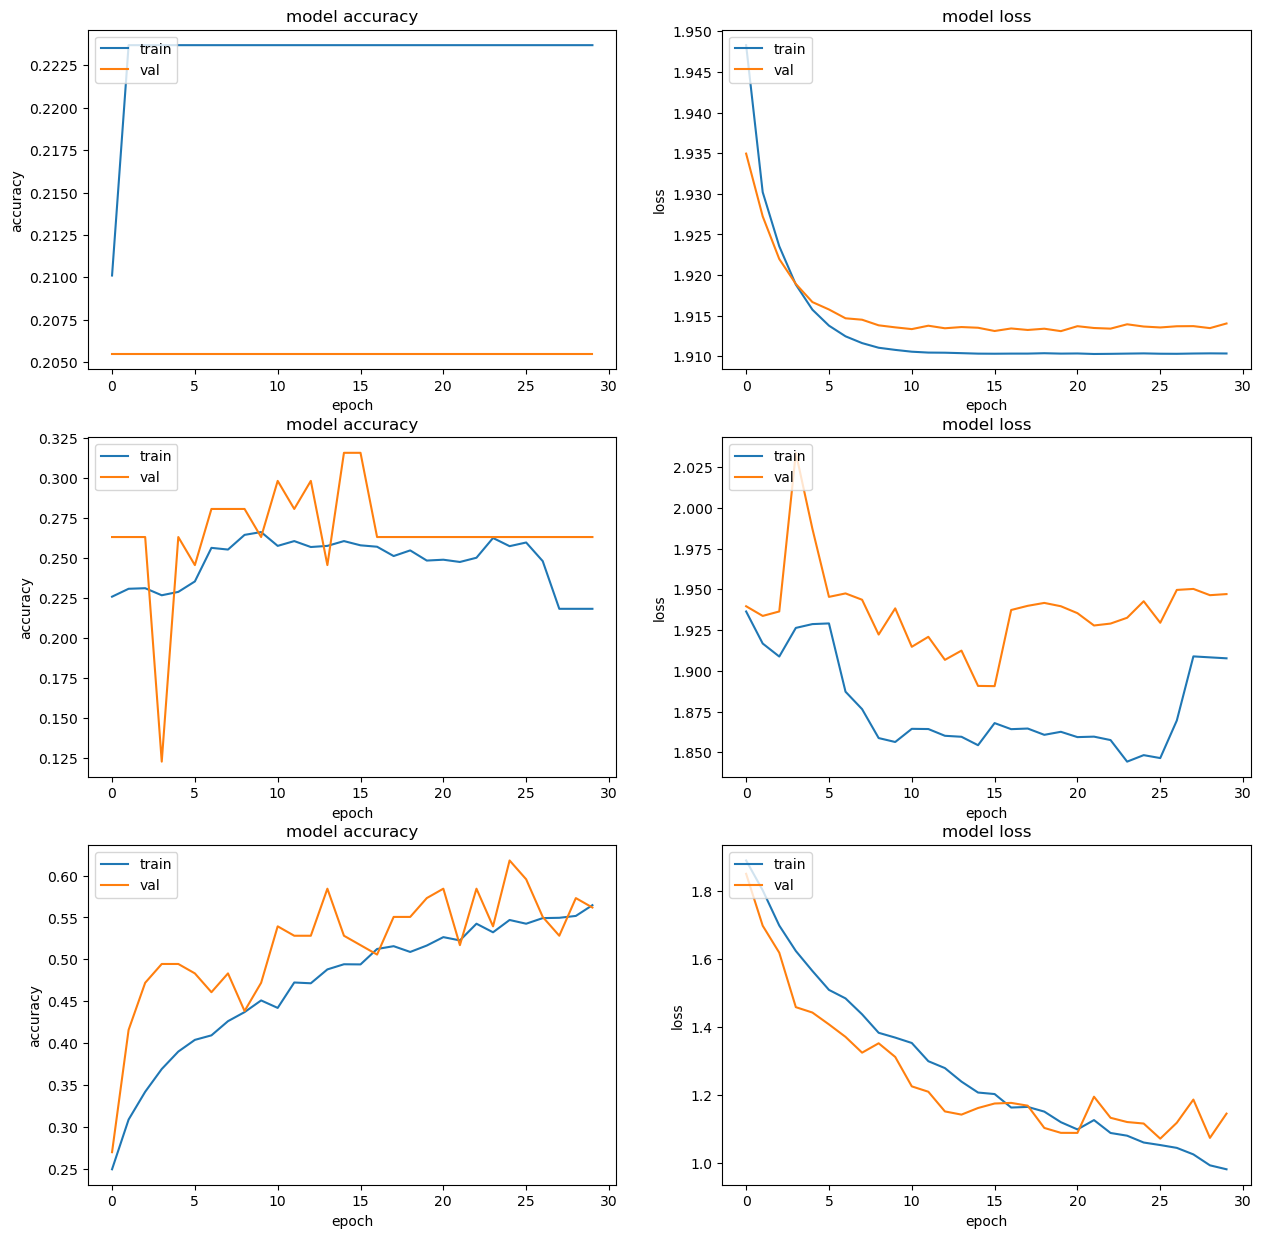

In [201]:
plot_stats(ac1_6)

# EMOVO

In [202]:
kf2 = leave_one_speaker_out(data["emovo"]["metadata"], n=3)    

In [203]:
ac2_1 = train_avaluate(get_m1, kf2, data["emovo"]["x"], data["emovo"]["y"])

Epoch 1/30
92/92 [==============================] - 12s 76ms/step - loss: 1.9549 - accuracy: 0.1403 - val_loss: 1.9476 - val_accuracy: 0.1597
Epoch 2/30
92/92 [==============================] - 6s 65ms/step - loss: 1.9394 - accuracy: 0.1442 - val_loss: 1.9432 - val_accuracy: 0.1261
Epoch 3/30
92/92 [==============================] - 6s 65ms/step - loss: 1.9329 - accuracy: 0.1693 - val_loss: 1.9382 - val_accuracy: 0.1849
Epoch 4/30
92/92 [==============================] - 6s 65ms/step - loss: 1.9415 - accuracy: 0.1607 - val_loss: 1.9284 - val_accuracy: 0.2017
Epoch 5/30
92/92 [==============================] - 6s 65ms/step - loss: 1.9297 - accuracy: 0.1620 - val_loss: 1.9119 - val_accuracy: 0.2269
Epoch 6/30
92/92 [==============================] - 6s 64ms/step - loss: 1.9181 - accuracy: 0.1665 - val_loss: 1.9238 - val_accuracy: 0.2017
Epoch 7/30
92/92 [==============================] - 6s 64ms/step - loss: 1.9001 - accuracy: 0.1782 - val_loss: 1.9106 - val_accuracy: 0.1765
Epoch 8/30
9

Epoch 29/30
91/91 [==============================] - 6s 65ms/step - loss: 1.9220 - accuracy: 0.1849 - val_loss: 1.9503 - val_accuracy: 0.1220
Epoch 30/30
91/91 [==============================] - 6s 65ms/step - loss: 1.9121 - accuracy: 0.1870 - val_loss: 1.9523 - val_accuracy: 0.1463
Done
Epoch 1/30
91/91 [==============================] - 9s 70ms/step - loss: 1.9737 - accuracy: 0.1432 - val_loss: 1.9471 - val_accuracy: 0.1440
Epoch 2/30
91/91 [==============================] - 6s 66ms/step - loss: 1.9444 - accuracy: 0.1516 - val_loss: 1.9465 - val_accuracy: 0.1520
Epoch 3/30
91/91 [==============================] - 6s 64ms/step - loss: 1.9443 - accuracy: 0.1604 - val_loss: 1.9468 - val_accuracy: 0.1760
Epoch 4/30
91/91 [==============================] - 6s 64ms/step - loss: 1.9429 - accuracy: 0.1653 - val_loss: 1.9471 - val_accuracy: 0.1600
Epoch 5/30
91/91 [==============================] - 6s 65ms/step - loss: 1.9433 - accuracy: 0.1557 - val_loss: 1.9474 - val_accuracy: 0.1360
Epoch 

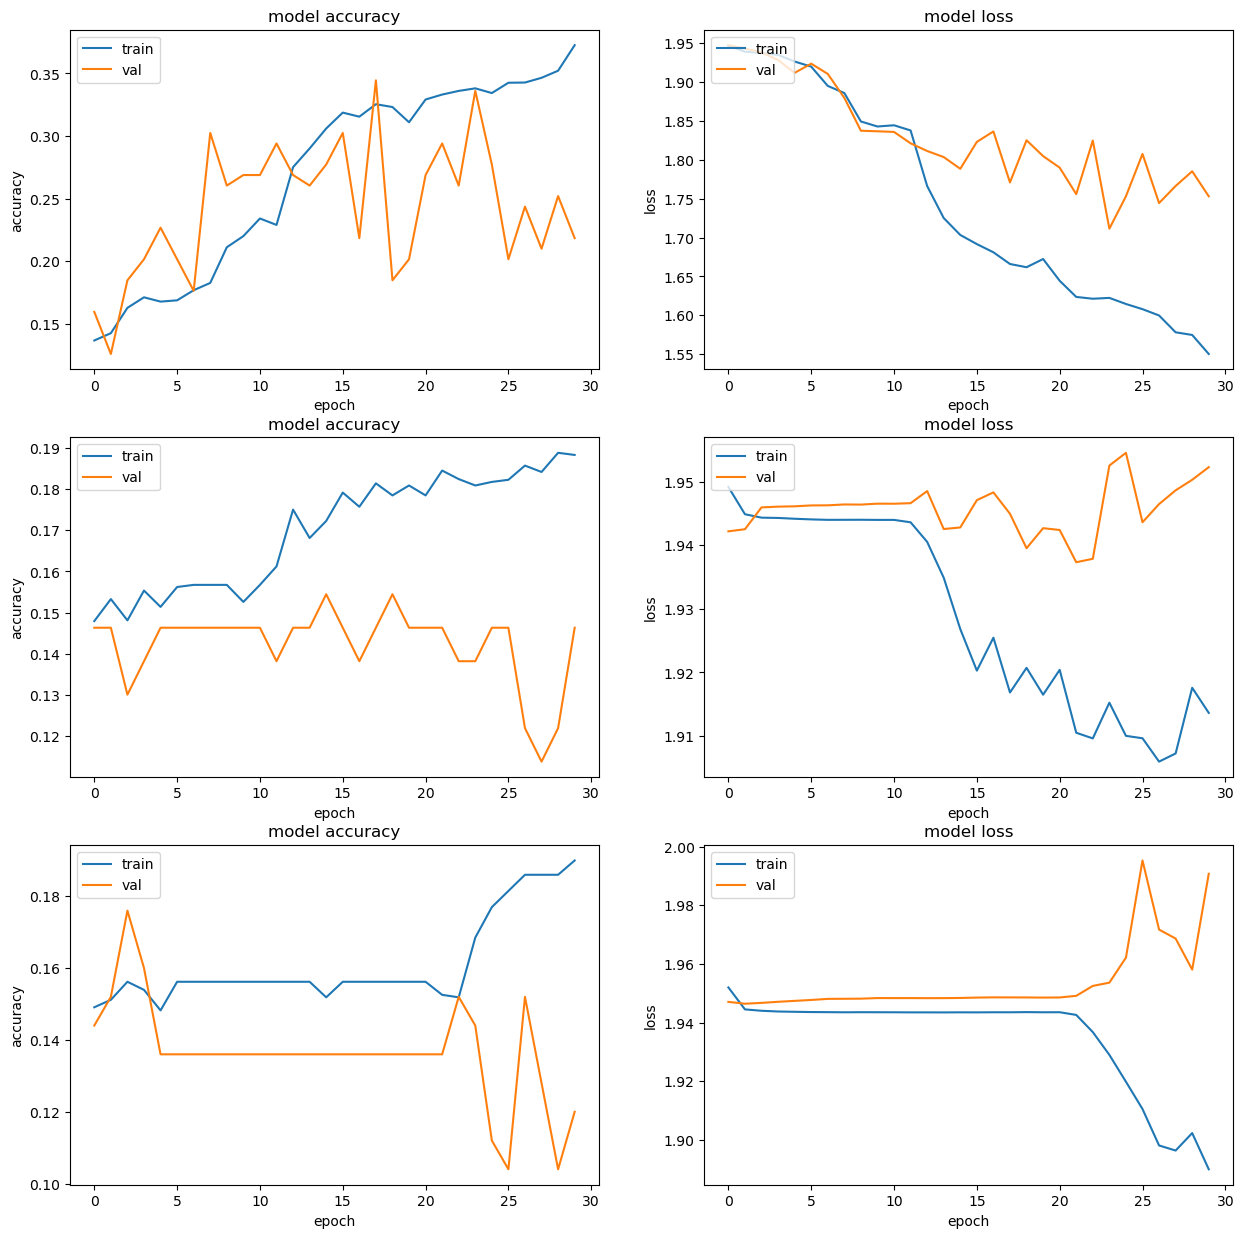

In [204]:
plot_stats(ac2_1)

In [206]:
ac2_2 = train_avaluate(get_m2, kf2, data["emovo"]["x"], data["emovo"]["y"])

Epoch 1/30
92/92 [==============================] - 8s 70ms/step - loss: 1.9549 - accuracy: 0.1393 - val_loss: 1.9425 - val_accuracy: 0.1429
Epoch 2/30
92/92 [==============================] - 6s 64ms/step - loss: 1.9451 - accuracy: 0.1428 - val_loss: 1.9437 - val_accuracy: 0.1429
Epoch 3/30
92/92 [==============================] - 6s 65ms/step - loss: 1.9231 - accuracy: 0.1576 - val_loss: 1.9419 - val_accuracy: 0.1765
Epoch 4/30
92/92 [==============================] - 6s 65ms/step - loss: 1.8938 - accuracy: 0.1871 - val_loss: 1.9592 - val_accuracy: 0.1597
Epoch 5/30
92/92 [==============================] - 6s 65ms/step - loss: 1.8810 - accuracy: 0.2194 - val_loss: 1.9479 - val_accuracy: 0.1513
Epoch 6/30
92/92 [==============================] - 6s 65ms/step - loss: 1.8435 - accuracy: 0.2186 - val_loss: 1.9552 - val_accuracy: 0.1681
Epoch 7/30
92/92 [==============================] - 6s 65ms/step - loss: 1.8465 - accuracy: 0.2442 - val_loss: 1.9005 - val_accuracy: 0.2017
Epoch 8/30
92

Epoch 29/30
91/91 [==============================] - 6s 65ms/step - loss: 0.7823 - accuracy: 0.6987 - val_loss: 1.8927 - val_accuracy: 0.3008
Epoch 30/30
91/91 [==============================] - 6s 64ms/step - loss: 0.7744 - accuracy: 0.6942 - val_loss: 1.9646 - val_accuracy: 0.2602
Done
Epoch 1/30
91/91 [==============================] - 8s 70ms/step - loss: 1.9539 - accuracy: 0.1474 - val_loss: 1.9546 - val_accuracy: 0.1360
Epoch 2/30
91/91 [==============================] - 6s 64ms/step - loss: 1.8814 - accuracy: 0.1876 - val_loss: 1.9065 - val_accuracy: 0.2080
Epoch 3/30
91/91 [==============================] - 6s 65ms/step - loss: 1.8315 - accuracy: 0.2318 - val_loss: 1.9313 - val_accuracy: 0.2160
Epoch 4/30
91/91 [==============================] - 6s 65ms/step - loss: 1.7682 - accuracy: 0.2576 - val_loss: 1.8480 - val_accuracy: 0.2800
Epoch 5/30
91/91 [==============================] - 6s 65ms/step - loss: 1.6683 - accuracy: 0.3136 - val_loss: 1.8189 - val_accuracy: 0.3280
Epoch 

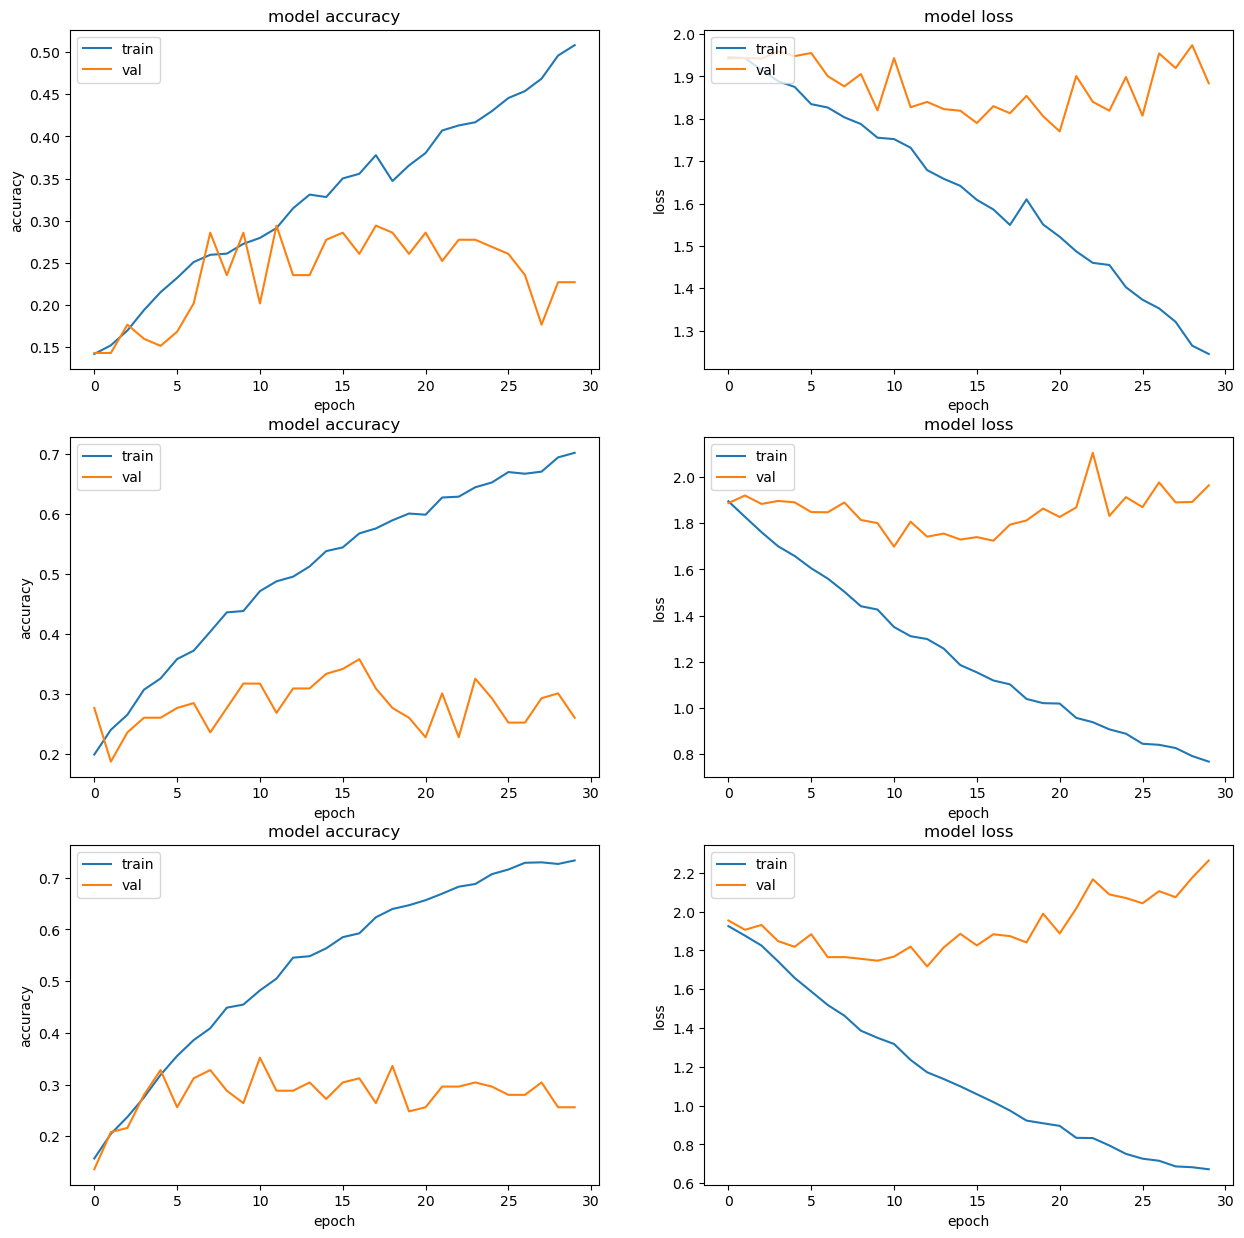

In [207]:
plot_stats(ac2_2)

In [208]:
ac2_3 = train_avaluate(get_m3, kf2, data["emovo"]["x"], data["emovo"]["y"])

Epoch 1/30
92/92 [==============================] - 14s 135ms/step - loss: 1.9496 - accuracy: 0.1408 - val_loss: 1.9452 - val_accuracy: 0.1429
Epoch 2/30
92/92 [==============================] - 12s 131ms/step - loss: 1.9452 - accuracy: 0.1502 - val_loss: 1.9446 - val_accuracy: 0.1681
Epoch 3/30
92/92 [==============================] - 12s 131ms/step - loss: 1.9447 - accuracy: 0.1458 - val_loss: 1.9443 - val_accuracy: 0.1681
Epoch 4/30
92/92 [==============================] - 12s 131ms/step - loss: 1.9449 - accuracy: 0.1382 - val_loss: 1.9441 - val_accuracy: 0.1681
Epoch 5/30
92/92 [==============================] - 12s 131ms/step - loss: 1.9446 - accuracy: 0.1605 - val_loss: 1.9439 - val_accuracy: 0.1681
Epoch 6/30
92/92 [==============================] - 12s 131ms/step - loss: 1.9445 - accuracy: 0.1536 - val_loss: 1.9440 - val_accuracy: 0.1681
Epoch 7/30
92/92 [==============================] - 12s 131ms/step - loss: 1.9448 - accuracy: 0.1473 - val_loss: 1.9439 - val_accuracy: 0.1429

Epoch 28/30
91/91 [==============================] - 12s 132ms/step - loss: 1.9445 - accuracy: 0.1457 - val_loss: 1.9466 - val_accuracy: 0.1463
Epoch 29/30
91/91 [==============================] - 12s 132ms/step - loss: 1.9440 - accuracy: 0.1520 - val_loss: 1.9465 - val_accuracy: 0.1463
Epoch 30/30
91/91 [==============================] - 12s 131ms/step - loss: 1.9435 - accuracy: 0.1568 - val_loss: 1.9466 - val_accuracy: 0.1463
Done
Epoch 1/30
91/91 [==============================] - 13s 135ms/step - loss: 1.9589 - accuracy: 0.1524 - val_loss: 1.9453 - val_accuracy: 0.1440
Epoch 2/30
91/91 [==============================] - 12s 132ms/step - loss: 1.9448 - accuracy: 0.1565 - val_loss: 1.9461 - val_accuracy: 0.1360
Epoch 3/30
91/91 [==============================] - 12s 130ms/step - loss: 1.9440 - accuracy: 0.1576 - val_loss: 1.9466 - val_accuracy: 0.1360
Epoch 4/30
91/91 [==============================] - 12s 130ms/step - loss: 1.9443 - accuracy: 0.1533 - val_loss: 1.9470 - val_accuracy

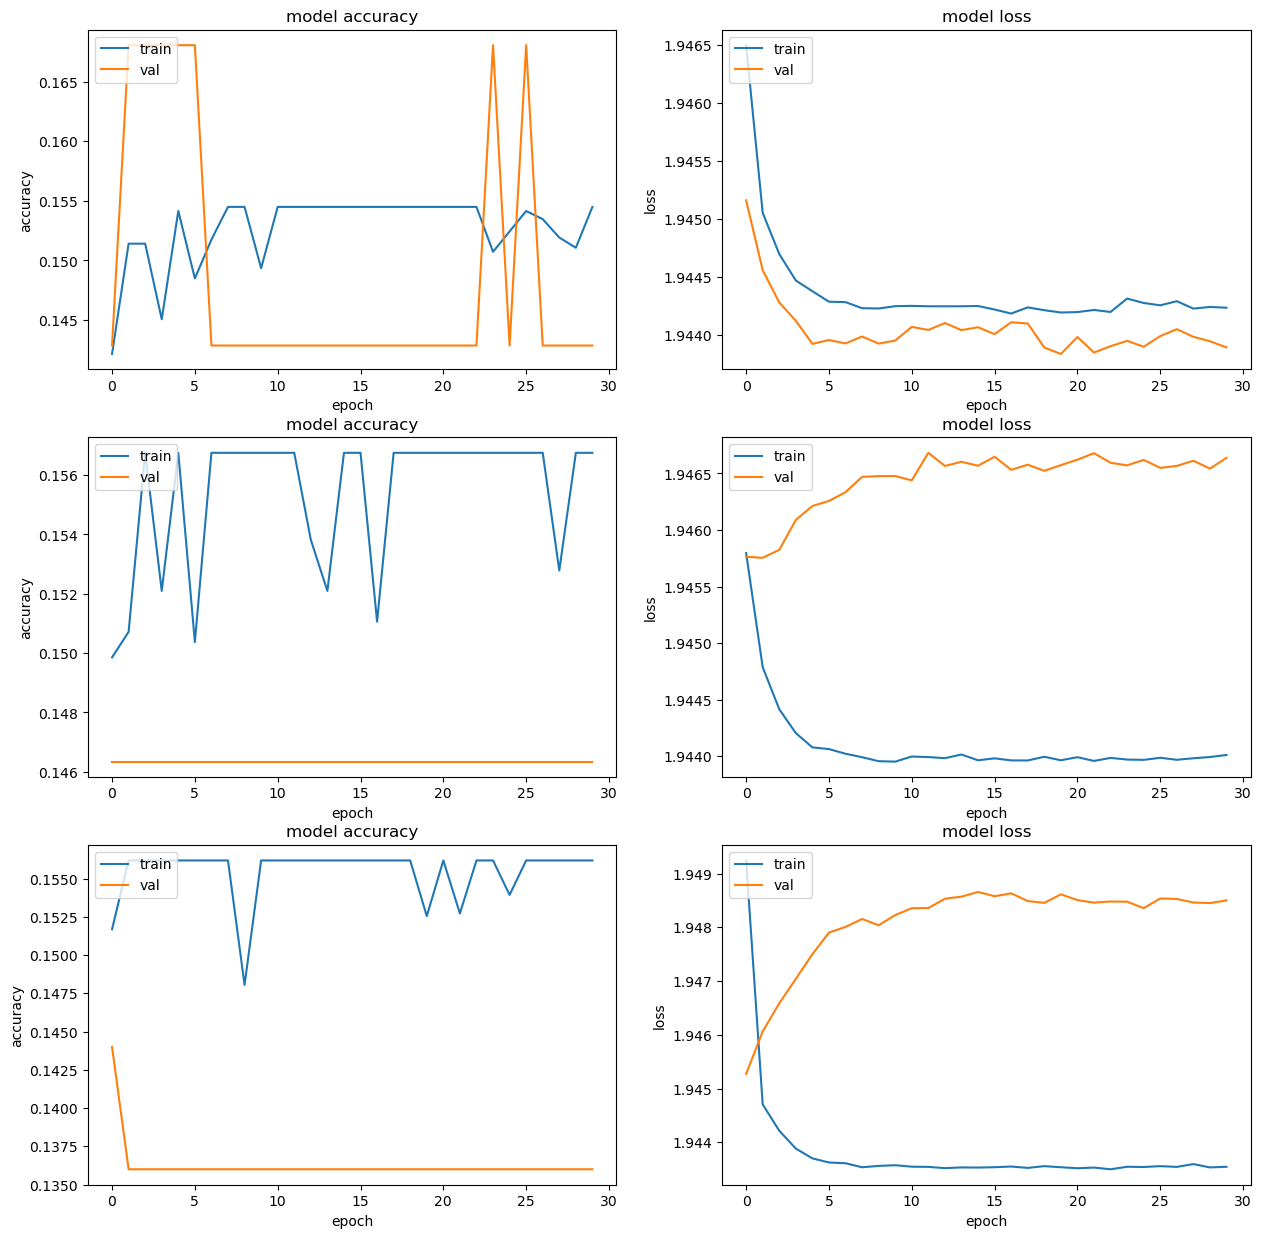

In [209]:
plot_stats(ac2_3)

In [211]:
ac2_4 = train_avaluate(get_m4, kf2, data["emovo"]["x"], data["emovo"]["y"])

Epoch 1/30
92/92 [==============================] - 8s 74ms/step - loss: 1.9496 - accuracy: 0.1410 - val_loss: 1.9446 - val_accuracy: 0.1597
Epoch 2/30
92/92 [==============================] - 6s 69ms/step - loss: 1.9450 - accuracy: 0.1511 - val_loss: 1.9443 - val_accuracy: 0.1429
Epoch 3/30
92/92 [==============================] - 6s 70ms/step - loss: 1.9436 - accuracy: 0.1538 - val_loss: 1.9442 - val_accuracy: 0.1681
Epoch 4/30
92/92 [==============================] - 6s 69ms/step - loss: 1.9430 - accuracy: 0.1574 - val_loss: 1.9462 - val_accuracy: 0.1681
Epoch 5/30
92/92 [==============================] - 6s 69ms/step - loss: 1.9426 - accuracy: 0.1412 - val_loss: 1.9430 - val_accuracy: 0.1681
Epoch 6/30
92/92 [==============================] - 6s 69ms/step - loss: 1.9407 - accuracy: 0.1594 - val_loss: 1.9441 - val_accuracy: 0.1681
Epoch 7/30
92/92 [==============================] - 6s 70ms/step - loss: 1.9356 - accuracy: 0.1629 - val_loss: 1.9441 - val_accuracy: 0.1681
Epoch 8/30
92

Epoch 29/30
91/91 [==============================] - 6s 70ms/step - loss: 1.9438 - accuracy: 0.1582 - val_loss: 1.9466 - val_accuracy: 0.1463
Epoch 30/30
91/91 [==============================] - 6s 69ms/step - loss: 1.9448 - accuracy: 0.1544 - val_loss: 1.9466 - val_accuracy: 0.1463
Done
Epoch 1/30
91/91 [==============================] - 8s 74ms/step - loss: 1.9479 - accuracy: 0.1462 - val_loss: 1.9468 - val_accuracy: 0.1360
Epoch 2/30
91/91 [==============================] - 6s 68ms/step - loss: 1.9446 - accuracy: 0.1547 - val_loss: 1.9466 - val_accuracy: 0.1360
Epoch 3/30
91/91 [==============================] - 6s 68ms/step - loss: 1.9433 - accuracy: 0.1584 - val_loss: 1.9352 - val_accuracy: 0.1520
Epoch 4/30
91/91 [==============================] - 6s 69ms/step - loss: 1.9330 - accuracy: 0.1666 - val_loss: 1.9531 - val_accuracy: 0.1520
Epoch 5/30
91/91 [==============================] - 6s 68ms/step - loss: 1.9318 - accuracy: 0.1723 - val_loss: 1.9442 - val_accuracy: 0.1600
Epoch 

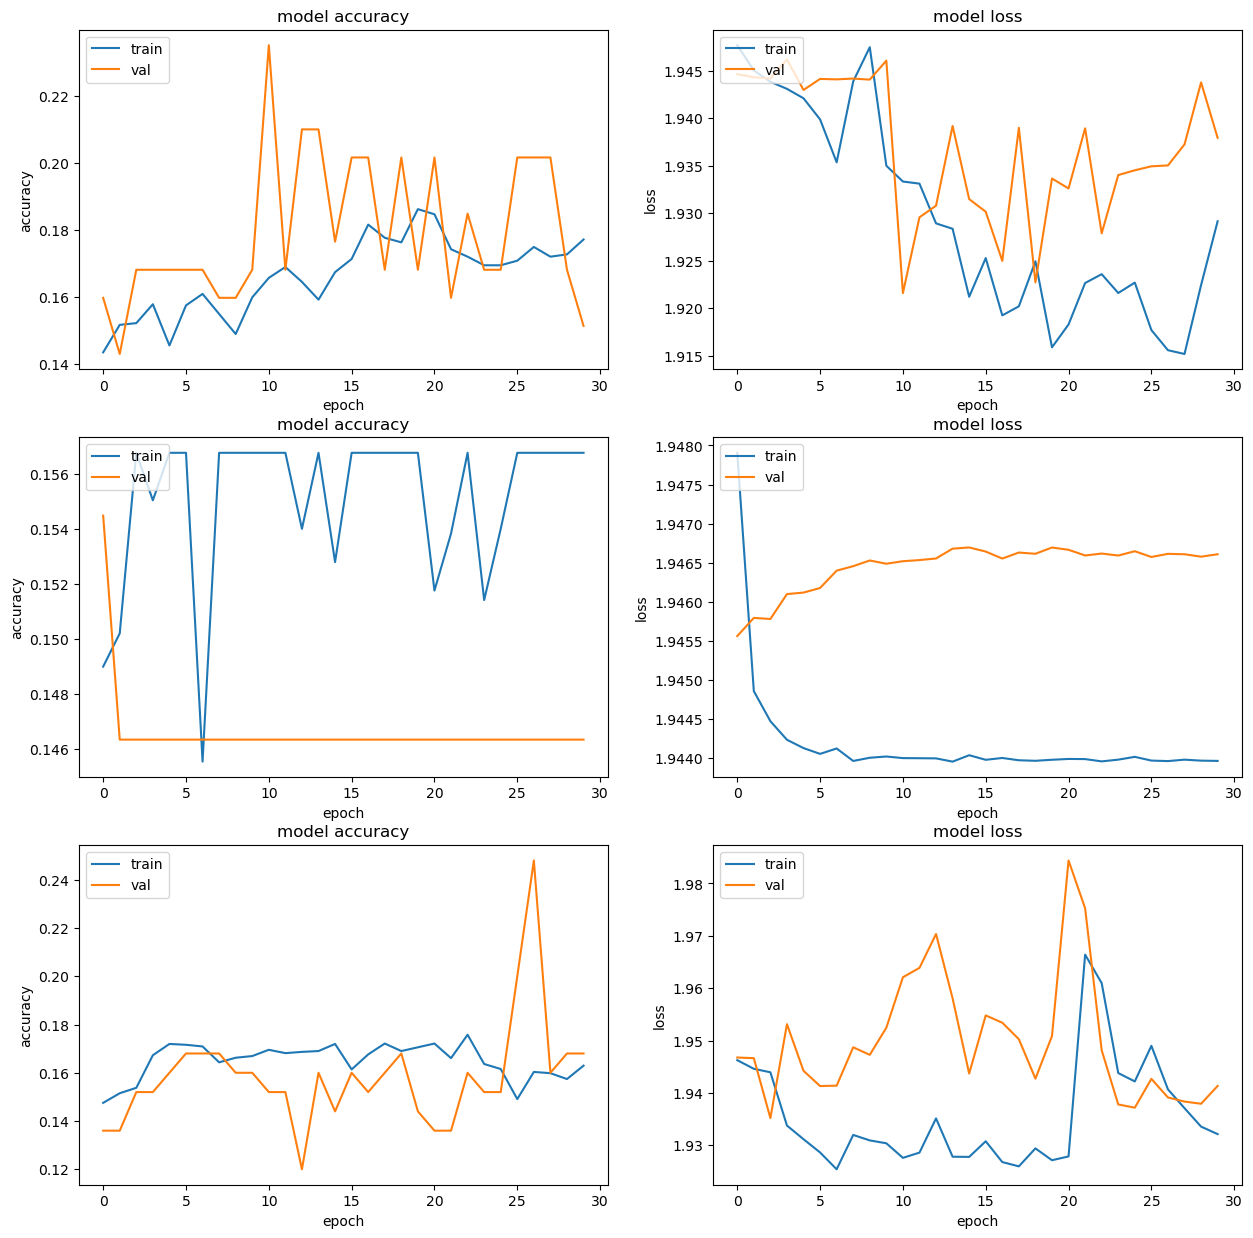

In [212]:
plot_stats(ac2_4)

In [213]:
ac2_5 = train_avaluate(get_m5, kf2, data["emovo"]["x"], data["emovo"]["y"] )

Epoch 1/30
92/92 [==============================] - 11s 77ms/step - loss: 1.9463 - accuracy: 0.1513 - val_loss: 1.9451 - val_accuracy: 0.1681
Epoch 2/30
92/92 [==============================] - 7s 71ms/step - loss: 1.9450 - accuracy: 0.1552 - val_loss: 1.9446 - val_accuracy: 0.1429
Epoch 3/30
92/92 [==============================] - 7s 72ms/step - loss: 1.9447 - accuracy: 0.1496 - val_loss: 1.9443 - val_accuracy: 0.1429
Epoch 4/30
92/92 [==============================] - 6s 68ms/step - loss: 1.9447 - accuracy: 0.1554 - val_loss: 1.9443 - val_accuracy: 0.1429
Epoch 5/30
92/92 [==============================] - 7s 74ms/step - loss: 1.9450 - accuracy: 0.1496 - val_loss: 1.9442 - val_accuracy: 0.1429
Epoch 6/30
92/92 [==============================] - 6s 69ms/step - loss: 1.9438 - accuracy: 0.1547 - val_loss: 1.9441 - val_accuracy: 0.1429
Epoch 7/30
92/92 [==============================] - 7s 74ms/step - loss: 1.9447 - accuracy: 0.1584 - val_loss: 1.9439 - val_accuracy: 0.1429
Epoch 8/30
9

Epoch 29/30
91/91 [==============================] - 6s 69ms/step - loss: 1.9442 - accuracy: 0.1541 - val_loss: 1.9466 - val_accuracy: 0.1463
Epoch 30/30
91/91 [==============================] - 6s 68ms/step - loss: 1.9455 - accuracy: 0.1591 - val_loss: 1.9466 - val_accuracy: 0.1463
Done
Epoch 1/30
91/91 [==============================] - 8s 77ms/step - loss: 1.9471 - accuracy: 0.1355 - val_loss: 1.9460 - val_accuracy: 0.1600
Epoch 2/30
91/91 [==============================] - 6s 68ms/step - loss: 1.9443 - accuracy: 0.1562 - val_loss: 1.9464 - val_accuracy: 0.1360
Epoch 3/30
91/91 [==============================] - 6s 68ms/step - loss: 1.9446 - accuracy: 0.1393 - val_loss: 1.9468 - val_accuracy: 0.1360
Epoch 4/30
91/91 [==============================] - 6s 68ms/step - loss: 1.9444 - accuracy: 0.1518 - val_loss: 1.9472 - val_accuracy: 0.1360
Epoch 5/30
91/91 [==============================] - 6s 67ms/step - loss: 1.9446 - accuracy: 0.1568 - val_loss: 1.9474 - val_accuracy: 0.1360
Epoch 

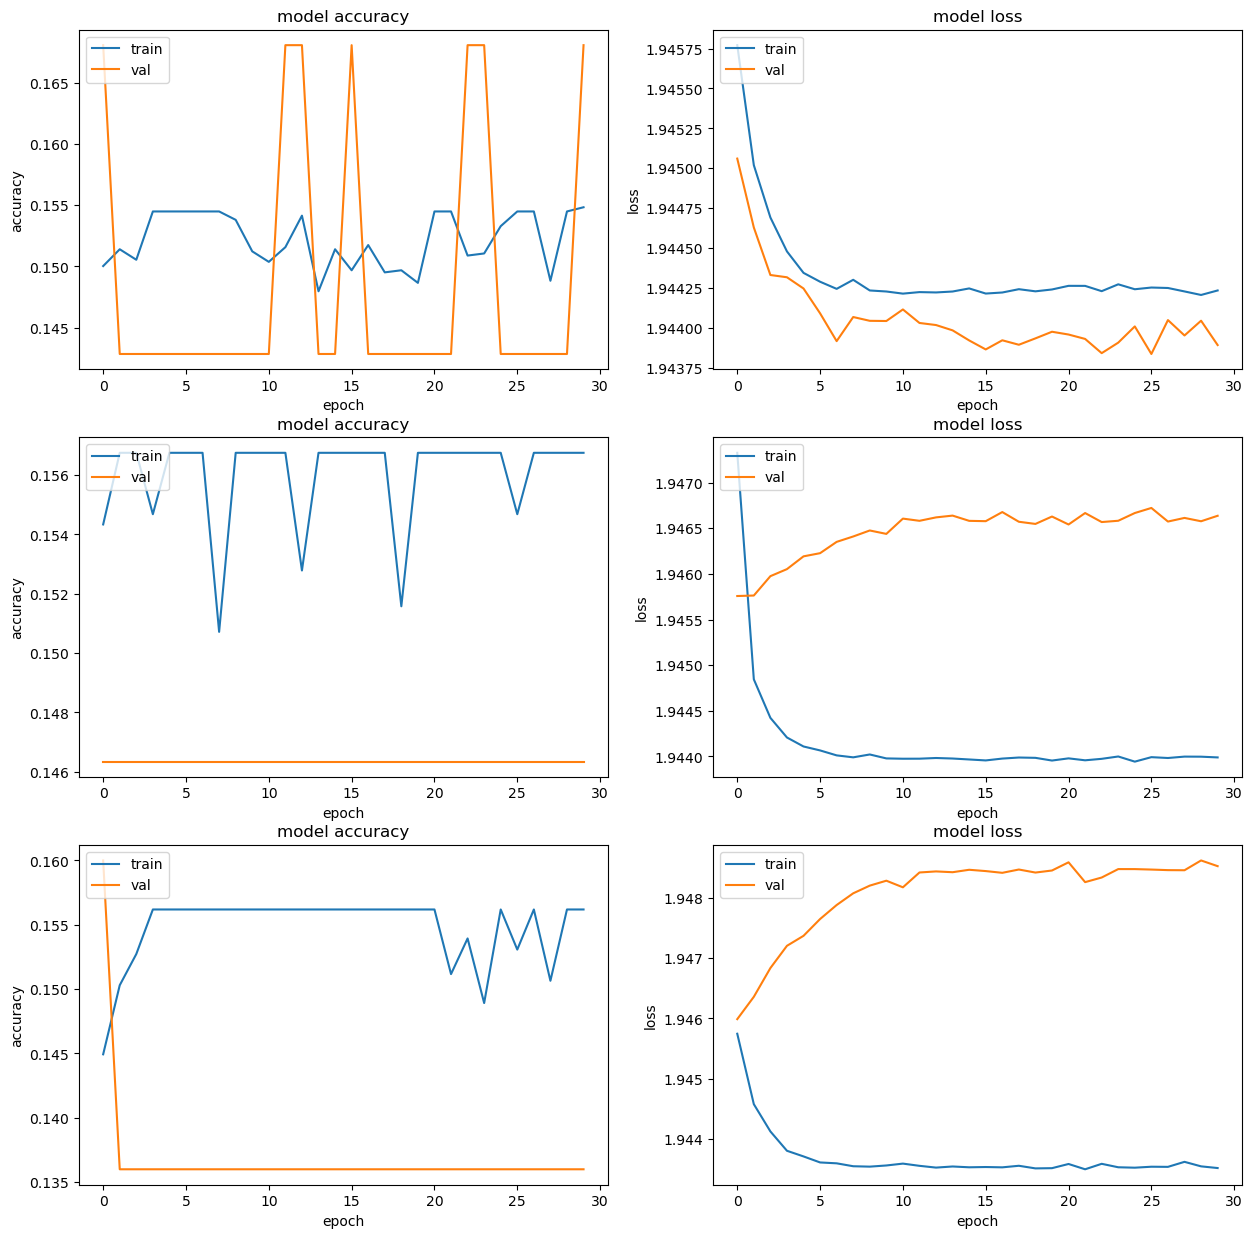

In [214]:
plot_stats(ac2_5)

In [215]:
ac2_6 = train_avaluate(get_m6, kf2, data["emovo"]["x"], data["emovo"]["y"] )

Epoch 1/30
92/92 [==============================] - 9s 79ms/step - loss: 1.9634 - accuracy: 0.1434 - val_loss: 1.9449 - val_accuracy: 0.1261
Epoch 2/30
92/92 [==============================] - 7s 71ms/step - loss: 1.9451 - accuracy: 0.1467 - val_loss: 1.9447 - val_accuracy: 0.1429
Epoch 3/30
92/92 [==============================] - 7s 71ms/step - loss: 1.9447 - accuracy: 0.1544 - val_loss: 1.9443 - val_accuracy: 0.1429
Epoch 4/30
92/92 [==============================] - 7s 72ms/step - loss: 1.9440 - accuracy: 0.1604 - val_loss: 1.9440 - val_accuracy: 0.1681
Epoch 5/30
92/92 [==============================] - 7s 71ms/step - loss: 1.9442 - accuracy: 0.1610 - val_loss: 1.9440 - val_accuracy: 0.1681
Epoch 6/30
92/92 [==============================] - 7s 71ms/step - loss: 1.9446 - accuracy: 0.1538 - val_loss: 1.9440 - val_accuracy: 0.1429
Epoch 7/30
92/92 [==============================] - 7s 72ms/step - loss: 1.9449 - accuracy: 0.1483 - val_loss: 1.9441 - val_accuracy: 0.1429
Epoch 8/30
92

Epoch 29/30
91/91 [==============================] - 6s 71ms/step - loss: 1.9445 - accuracy: 0.1535 - val_loss: 1.9466 - val_accuracy: 0.1463
Epoch 30/30
91/91 [==============================] - 6s 70ms/step - loss: 1.9428 - accuracy: 0.1645 - val_loss: 1.9466 - val_accuracy: 0.1463
Done
Epoch 1/30
91/91 [==============================] - 9s 78ms/step - loss: 1.9610 - accuracy: 0.1492 - val_loss: 1.9459 - val_accuracy: 0.1600
Epoch 2/30
91/91 [==============================] - 6s 71ms/step - loss: 1.9448 - accuracy: 0.1560 - val_loss: 1.9463 - val_accuracy: 0.1600
Epoch 3/30
91/91 [==============================] - 6s 70ms/step - loss: 1.9437 - accuracy: 0.1603 - val_loss: 1.9468 - val_accuracy: 0.1360
Epoch 4/30
91/91 [==============================] - 6s 71ms/step - loss: 1.9449 - accuracy: 0.1477 - val_loss: 1.9472 - val_accuracy: 0.1360
Epoch 5/30
91/91 [==============================] - 7s 72ms/step - loss: 1.9441 - accuracy: 0.1471 - val_loss: 1.9474 - val_accuracy: 0.1360
Epoch 

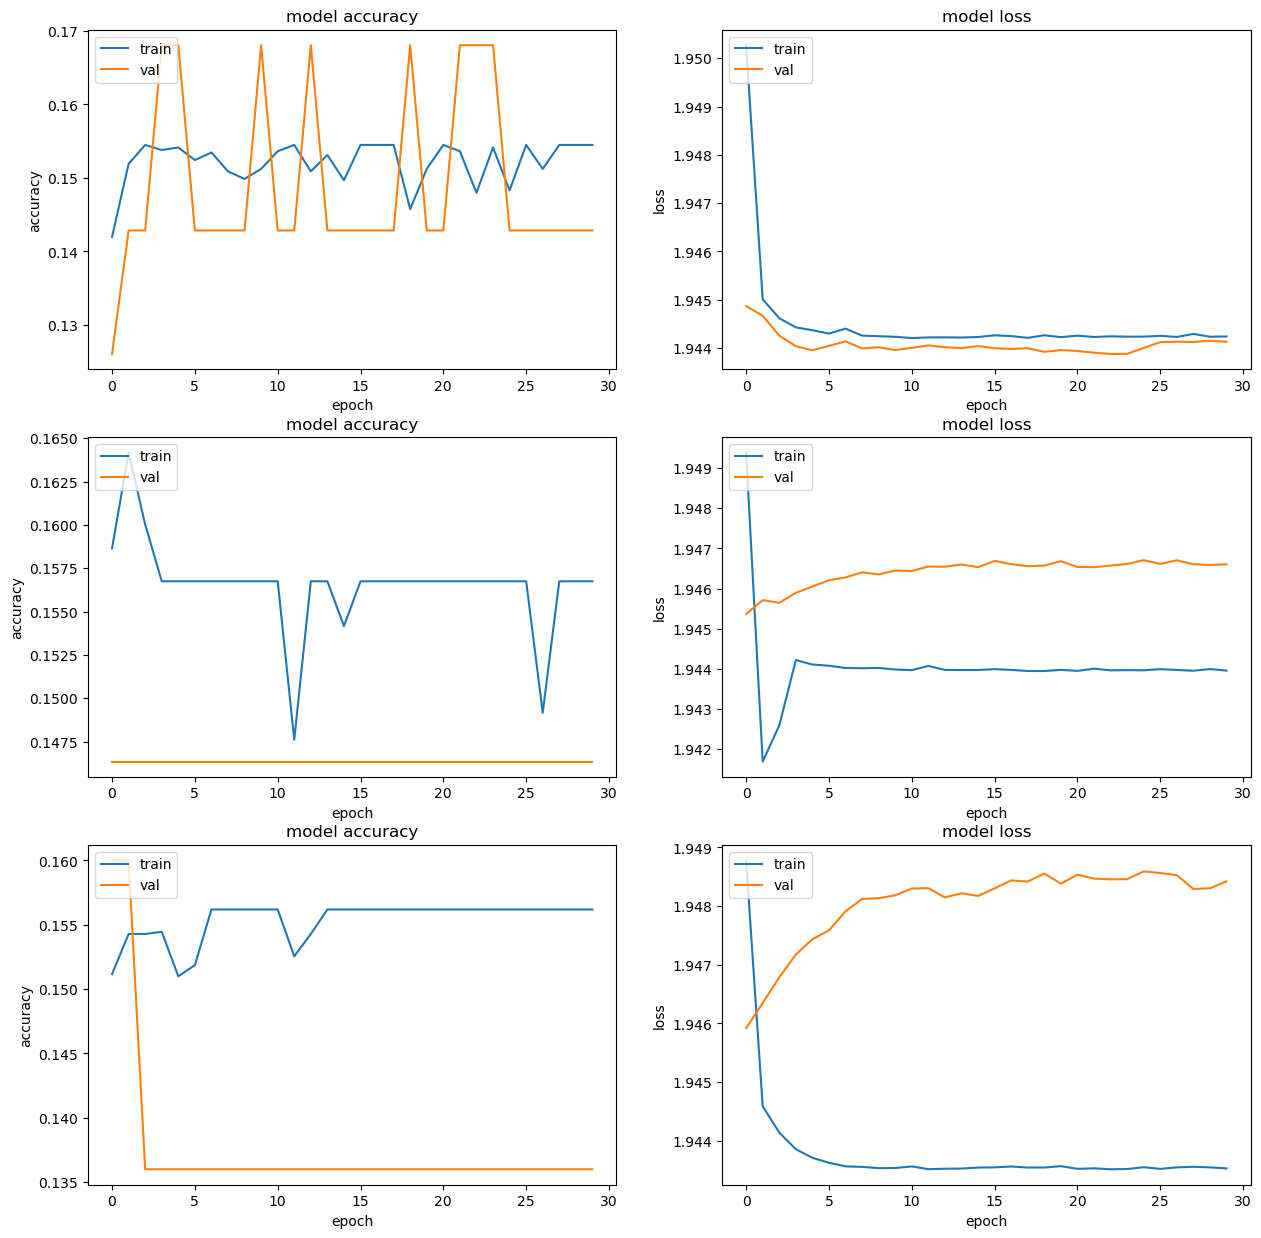

In [216]:
plot_stats(ac2_6)

# RAVDESS

In [14]:
kf3 = leave_one_speaker_out(data["ravdess"]["metadata"], n=3)    

In [219]:
ac3_1 = train_avaluate(get_m1, kf3, data["ravdess"]["x"], data["ravdess"]["y"])

Epoch 1/30
187/187 [==============================] - 15s 68ms/step - loss: 1.9495 - accuracy: 0.1508 - val_loss: 1.9460 - val_accuracy: 0.0877
Epoch 2/30
187/187 [==============================] - 12s 64ms/step - loss: 1.9264 - accuracy: 0.1829 - val_loss: 1.9297 - val_accuracy: 0.1404
Epoch 3/30
187/187 [==============================] - 12s 65ms/step - loss: 1.9064 - accuracy: 0.1998 - val_loss: 1.8546 - val_accuracy: 0.2281
Epoch 4/30
187/187 [==============================] - 12s 65ms/step - loss: 1.8664 - accuracy: 0.2275 - val_loss: 1.8309 - val_accuracy: 0.3333
Epoch 5/30
187/187 [==============================] - 12s 64ms/step - loss: 1.8481 - accuracy: 0.2223 - val_loss: 1.8586 - val_accuracy: 0.2632
Epoch 6/30
187/187 [==============================] - 12s 64ms/step - loss: 1.8116 - accuracy: 0.2502 - val_loss: 1.8273 - val_accuracy: 0.2982
Epoch 7/30
187/187 [==============================] - 12s 64ms/step - loss: 1.7758 - accuracy: 0.2691 - val_loss: 1.7962 - val_accuracy:

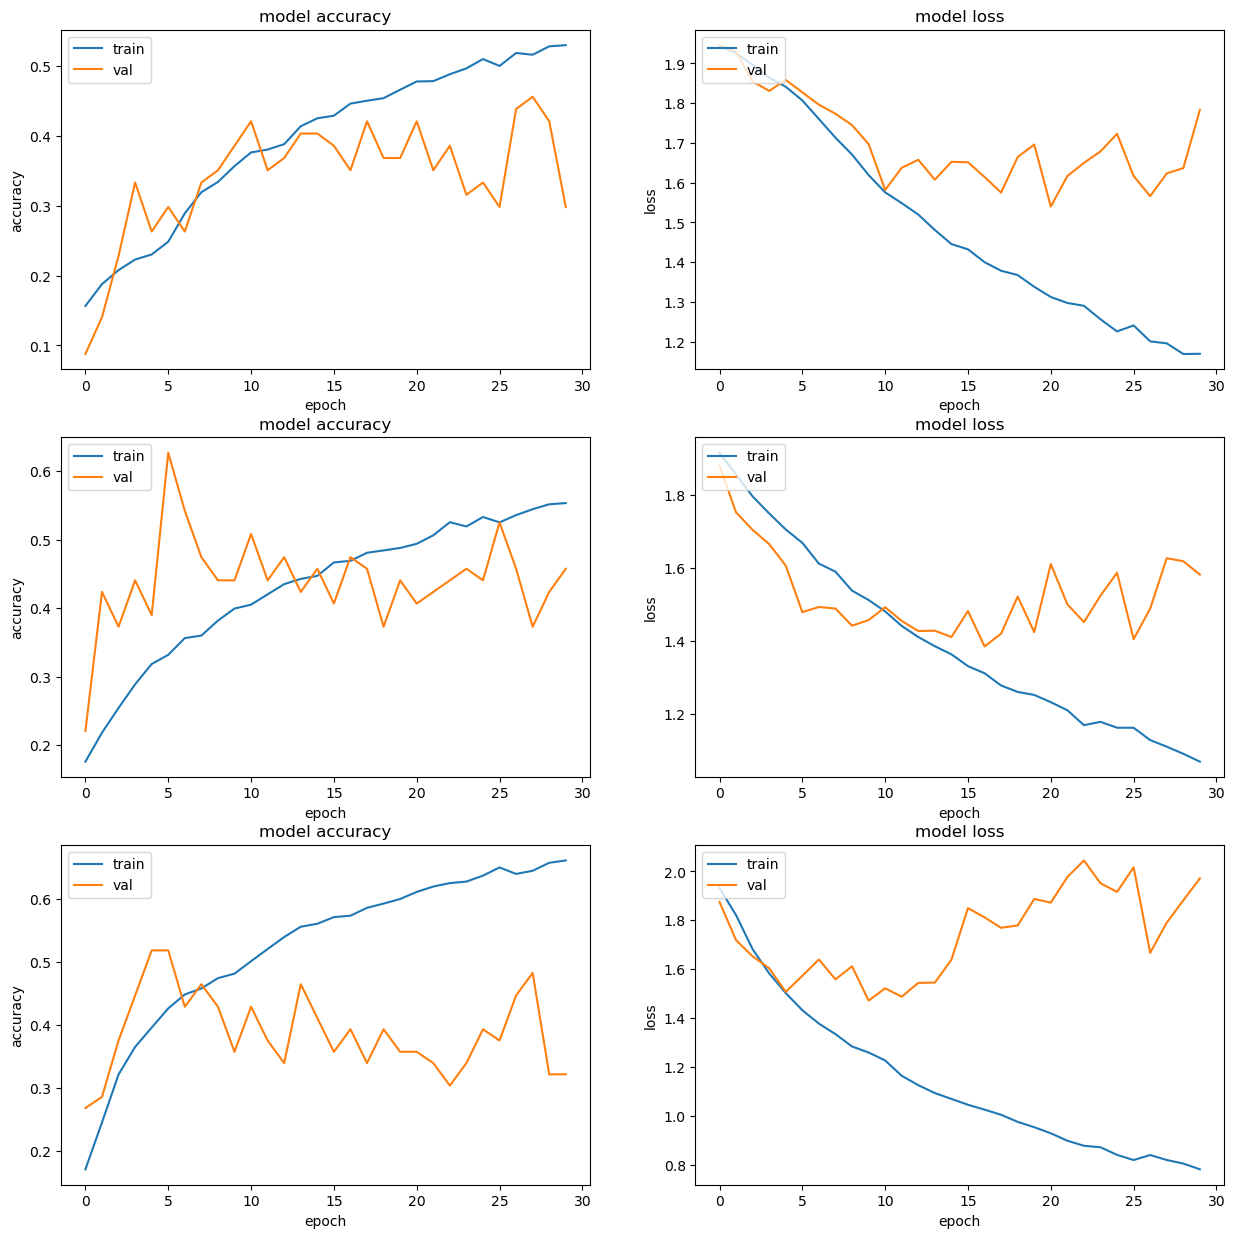

In [220]:
plot_stats(ac3_1)

In [15]:
ac3_2 = train_avaluate(get_m2, kf3, data["ravdess"]["x"], data["ravdess"]["y"])

2022-11-19 12:25:08.718934: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 9398648832 exceeds 10% of free system memory.
2022-11-19 12:25:13.972670: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-11-19 12:25:13.990106: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3301490000 Hz


Epoch 1/30


2022-11-19 12:25:15.584984: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-11-19 12:25:16.174701: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


187/187 [==============================] - 17s 64ms/step - loss: 1.9483 - accuracy: 0.1536 - val_loss: 1.9389 - val_accuracy: 0.1607
Epoch 2/30
187/187 [==============================] - 11s 57ms/step - loss: 1.9337 - accuracy: 0.1659 - val_loss: 1.9426 - val_accuracy: 0.1250
Epoch 3/30
187/187 [==============================] - 11s 58ms/step - loss: 1.9042 - accuracy: 0.2025 - val_loss: 1.8979 - val_accuracy: 0.2500
Epoch 4/30
187/187 [==============================] - 11s 58ms/step - loss: 1.8597 - accuracy: 0.2305 - val_loss: 1.7509 - val_accuracy: 0.3393
Epoch 5/30
187/187 [==============================] - 11s 58ms/step - loss: 1.8017 - accuracy: 0.2672 - val_loss: 1.7823 - val_accuracy: 0.2321
Epoch 6/30
187/187 [==============================] - 11s 59ms/step - loss: 1.7649 - accuracy: 0.2854 - val_loss: 1.7065 - val_accuracy: 0.2679
Epoch 7/30
187/187 [==============================] - 11s 58ms/step - loss: 1.7158 - accuracy: 0.2968 - val_loss: 1.7730 - val_accuracy: 0.3214
Epo

2022-11-19 12:30:59.473787: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 9389211648 exceeds 10% of free system memory.


Epoch 1/30
187/187 [==============================] - 13s 61ms/step - loss: 1.9405 - accuracy: 0.1693 - val_loss: 1.8922 - val_accuracy: 0.2456
Epoch 2/30
187/187 [==============================] - 11s 58ms/step - loss: 1.8434 - accuracy: 0.2316 - val_loss: 1.6976 - val_accuracy: 0.3684
Epoch 3/30
187/187 [==============================] - 11s 58ms/step - loss: 1.7274 - accuracy: 0.2973 - val_loss: 1.6747 - val_accuracy: 0.4035
Epoch 4/30
187/187 [==============================] - 11s 58ms/step - loss: 1.6577 - accuracy: 0.3436 - val_loss: 1.6055 - val_accuracy: 0.4211
Epoch 5/30
187/187 [==============================] - 11s 57ms/step - loss: 1.5600 - accuracy: 0.4003 - val_loss: 1.6166 - val_accuracy: 0.4211
Epoch 6/30
187/187 [==============================] - 11s 57ms/step - loss: 1.4935 - accuracy: 0.4204 - val_loss: 1.5111 - val_accuracy: 0.4561
Epoch 7/30
187/187 [==============================] - 11s 58ms/step - loss: 1.4320 - accuracy: 0.4430 - val_loss: 1.5678 - val_accuracy:

2022-11-19 12:36:41.769083: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 9389211648 exceeds 10% of free system memory.


Epoch 1/30
187/187 [==============================] - 14s 60ms/step - loss: 1.9254 - accuracy: 0.1803 - val_loss: 1.8051 - val_accuracy: 0.3509
Epoch 2/30
187/187 [==============================] - 11s 58ms/step - loss: 1.7529 - accuracy: 0.2903 - val_loss: 1.7809 - val_accuracy: 0.3333
Epoch 3/30
187/187 [==============================] - 14s 73ms/step - loss: 1.6464 - accuracy: 0.3580 - val_loss: 1.7473 - val_accuracy: 0.2807
Epoch 4/30
187/187 [==============================] - 11s 59ms/step - loss: 1.4761 - accuracy: 0.4265 - val_loss: 1.6139 - val_accuracy: 0.4737
Epoch 5/30
187/187 [==============================] - 11s 58ms/step - loss: 1.3647 - accuracy: 0.4782 - val_loss: 1.7969 - val_accuracy: 0.3509
Epoch 6/30
187/187 [==============================] - 11s 59ms/step - loss: 1.2572 - accuracy: 0.5165 - val_loss: 1.7234 - val_accuracy: 0.4386
Epoch 7/30
187/187 [==============================] - 11s 58ms/step - loss: 1.1892 - accuracy: 0.5499 - val_loss: 1.9081 - val_accuracy:

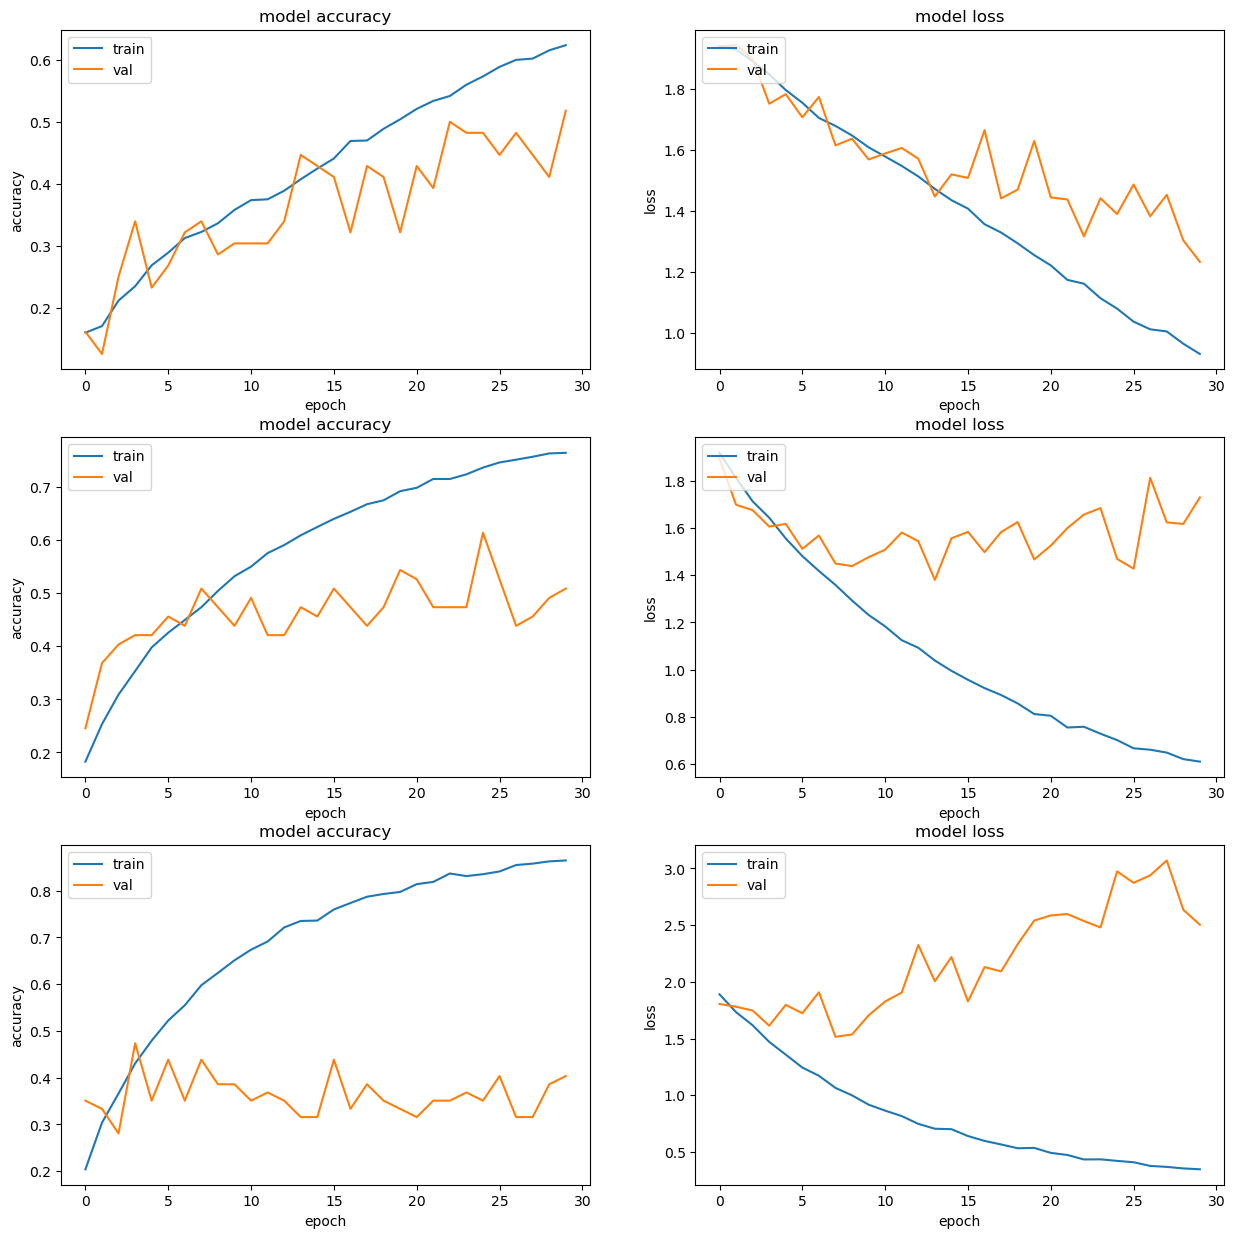

In [16]:
plot_stats(ac3_2)

In [17]:
ac3_3 = train_avaluate(get_m3, kf3, data["ravdess"]["x"], data["ravdess"]["y"])

2022-11-19 12:42:34.859637: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 9398648832 exceeds 10% of free system memory.


Epoch 1/30
187/187 [==============================] - 27s 134ms/step - loss: 1.9496 - accuracy: 0.1426 - val_loss: 1.9462 - val_accuracy: 0.1250
Epoch 2/30
187/187 [==============================] - 23s 125ms/step - loss: 1.9459 - accuracy: 0.1413 - val_loss: 1.9460 - val_accuracy: 0.1429
Epoch 3/30
187/187 [==============================] - 24s 126ms/step - loss: 1.9459 - accuracy: 0.1459 - val_loss: 1.9460 - val_accuracy: 0.1429
Epoch 4/30
187/187 [==============================] - 23s 126ms/step - loss: 1.9458 - accuracy: 0.1460 - val_loss: 1.9460 - val_accuracy: 0.1429
Epoch 5/30
187/187 [==============================] - 23s 125ms/step - loss: 1.9458 - accuracy: 0.1444 - val_loss: 1.9460 - val_accuracy: 0.1429
Epoch 6/30
187/187 [==============================] - 23s 125ms/step - loss: 1.9457 - accuracy: 0.1534 - val_loss: 1.9461 - val_accuracy: 0.1429
Epoch 7/30
187/187 [==============================] - 23s 125ms/step - loss: 1.9456 - accuracy: 0.1499 - val_loss: 1.9460 - val_ac

2022-11-19 12:54:38.483212: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 9389211648 exceeds 10% of free system memory.


Epoch 1/30
187/187 [==============================] - 26s 135ms/step - loss: 2.0307 - accuracy: 0.1403 - val_loss: 1.9521 - val_accuracy: 0.1404
Epoch 2/30
187/187 [==============================] - 24s 126ms/step - loss: 1.9615 - accuracy: 0.1488 - val_loss: 1.9459 - val_accuracy: 0.1404
Epoch 3/30
187/187 [==============================] - 23s 124ms/step - loss: 1.9558 - accuracy: 0.1380 - val_loss: 1.9457 - val_accuracy: 0.1579
Epoch 4/30
187/187 [==============================] - 24s 126ms/step - loss: 1.9470 - accuracy: 0.1424 - val_loss: 1.9457 - val_accuracy: 0.1579
Epoch 5/30
187/187 [==============================] - 23s 125ms/step - loss: 1.9479 - accuracy: 0.1413 - val_loss: 1.9456 - val_accuracy: 0.1579
Epoch 6/30
187/187 [==============================] - 23s 125ms/step - loss: 1.9467 - accuracy: 0.1448 - val_loss: 1.9456 - val_accuracy: 0.1579
Epoch 7/30
187/187 [==============================] - 23s 125ms/step - loss: 1.9473 - accuracy: 0.1440 - val_loss: 1.9456 - val_ac

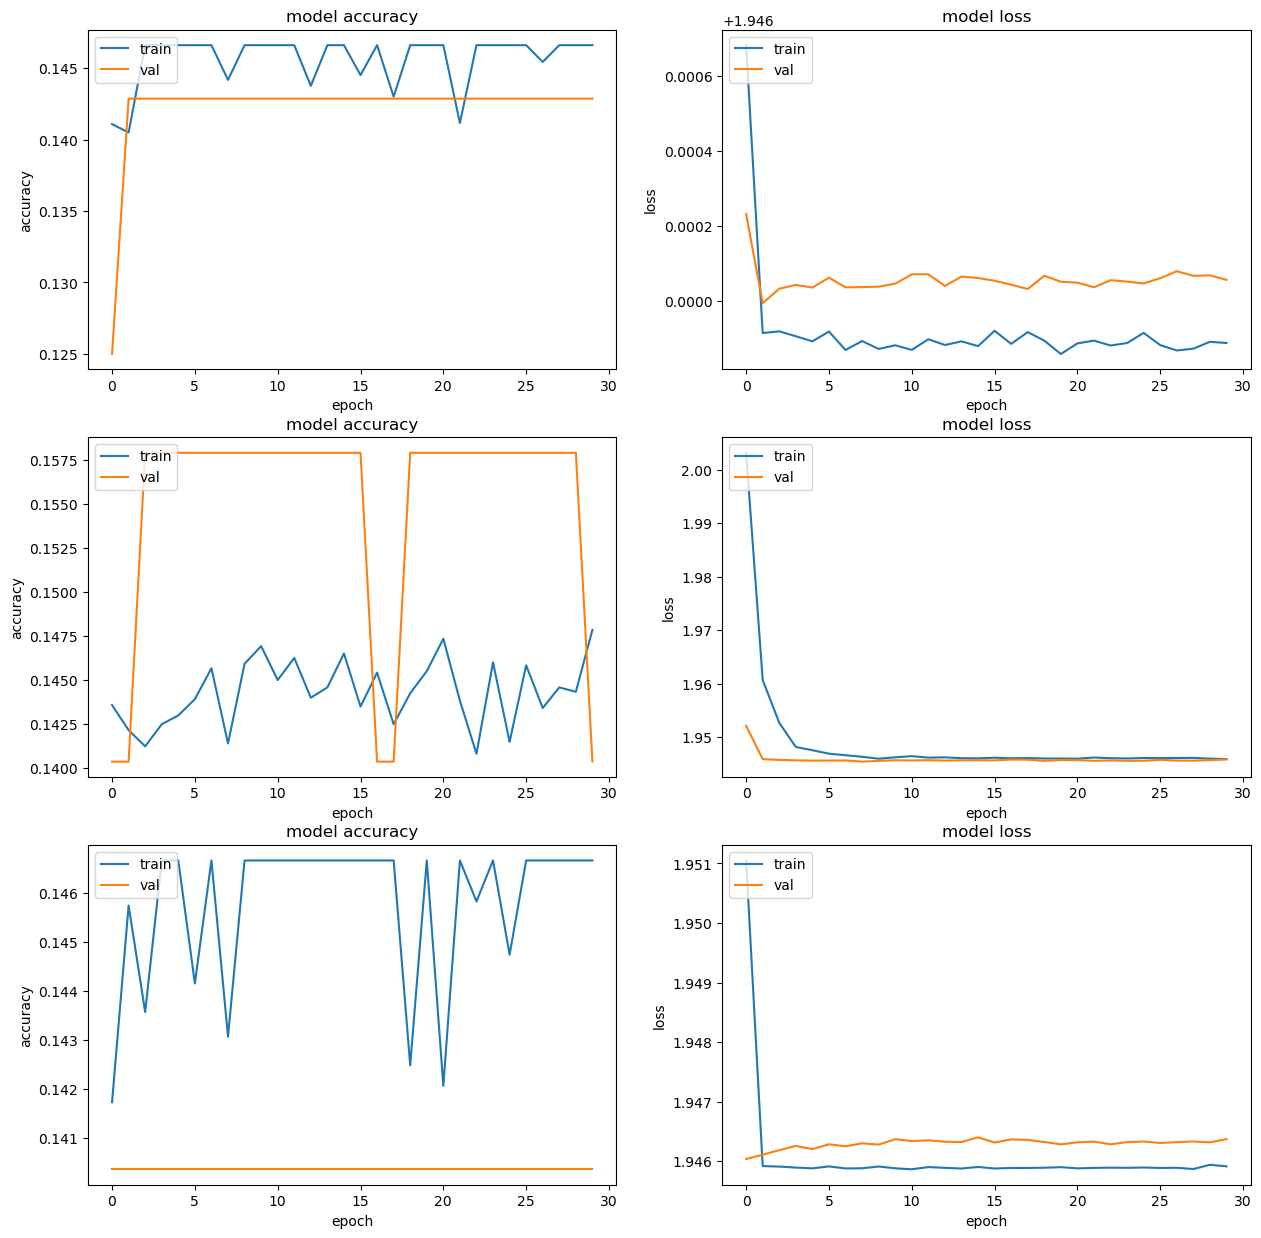

In [18]:
plot_stats(ac3_3)

In [19]:
ac3_4 = train_avaluate(get_m4, kf3, data["ravdess"]["x"], data["ravdess"]["y"])

Epoch 1/30
187/187 [==============================] - 16s 80ms/step - loss: 1.9466 - accuracy: 0.1375 - val_loss: 1.9454 - val_accuracy: 0.1429
Epoch 2/30
187/187 [==============================] - 13s 71ms/step - loss: 1.9460 - accuracy: 0.1349 - val_loss: 1.9460 - val_accuracy: 0.1429
Epoch 3/30
187/187 [==============================] - 14s 76ms/step - loss: 1.9459 - accuracy: 0.1438 - val_loss: 1.9460 - val_accuracy: 0.1429
Epoch 4/30
187/187 [==============================] - 16s 84ms/step - loss: 1.9458 - accuracy: 0.1418 - val_loss: 1.9460 - val_accuracy: 0.1429
Epoch 5/30
187/187 [==============================] - 13s 70ms/step - loss: 1.9457 - accuracy: 0.1514 - val_loss: 1.9460 - val_accuracy: 0.1429
Epoch 6/30
187/187 [==============================] - 14s 72ms/step - loss: 1.9461 - accuracy: 0.1399 - val_loss: 1.9461 - val_accuracy: 0.1429
Epoch 7/30
187/187 [==============================] - 13s 70ms/step - loss: 1.9455 - accuracy: 0.1508 - val_loss: 1.9461 - val_accuracy:

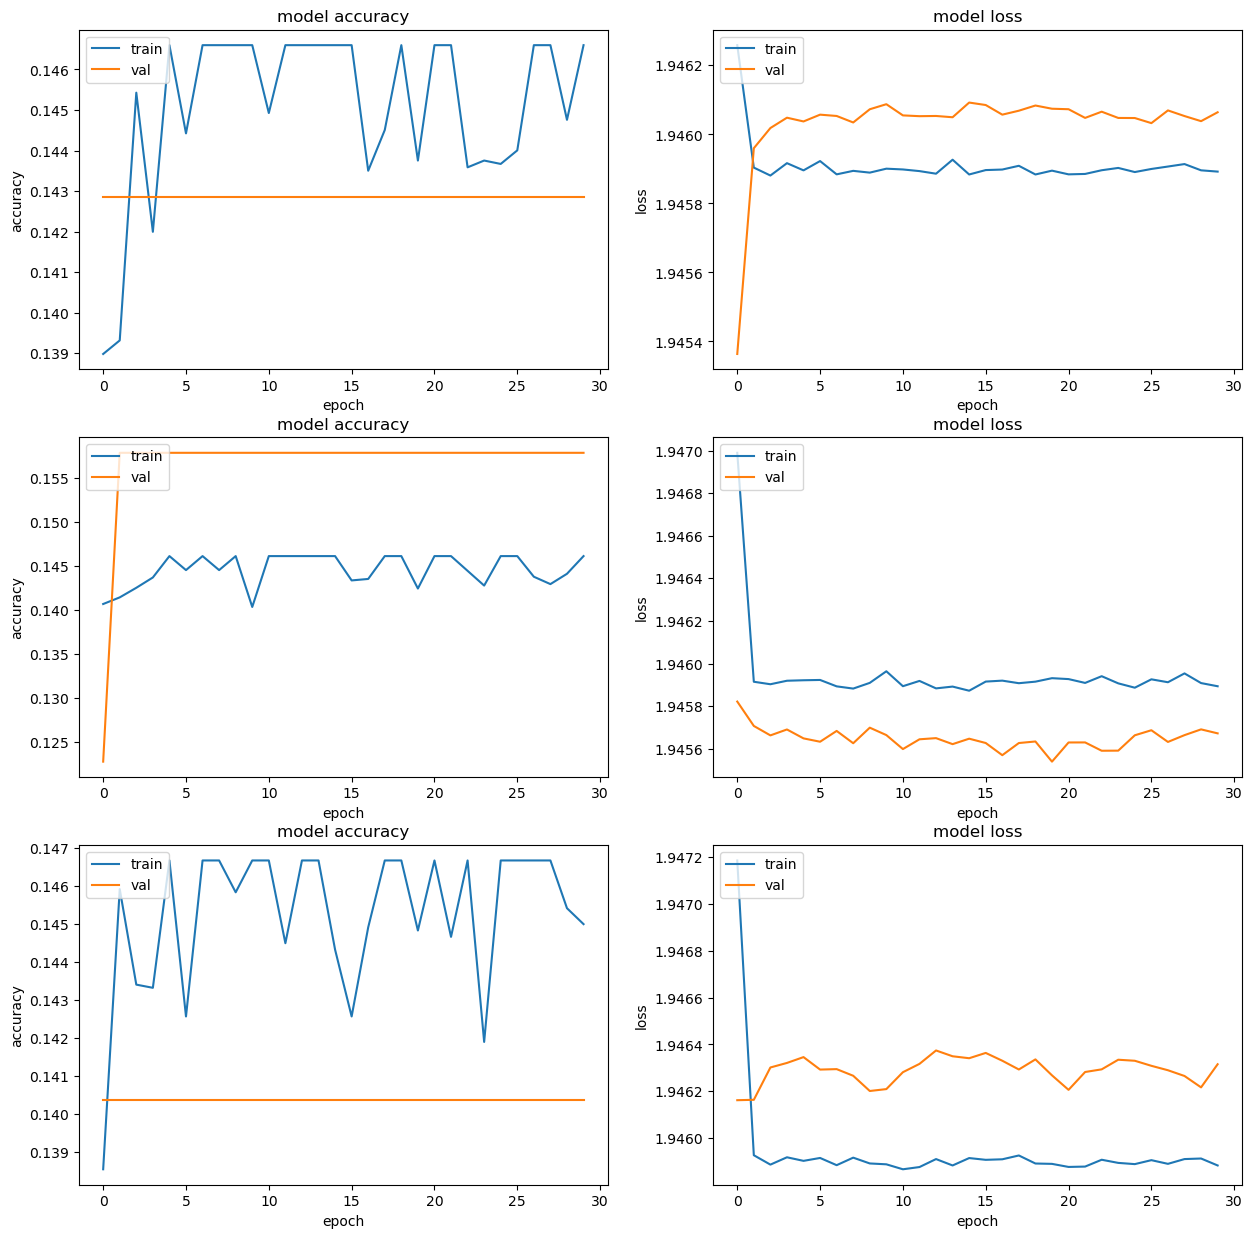

In [20]:
plot_stats(ac3_4)

In [21]:
ac3_5 = train_avaluate(get_m5, kf3, data["ravdess"]["x"], data["ravdess"]["y"] )

Epoch 1/30
187/187 [==============================] - 17s 81ms/step - loss: 1.9499 - accuracy: 0.1412 - val_loss: 1.9457 - val_accuracy: 0.1250
Epoch 2/30
187/187 [==============================] - 14s 72ms/step - loss: 1.9459 - accuracy: 0.1463 - val_loss: 1.9460 - val_accuracy: 0.1429
Epoch 3/30
187/187 [==============================] - 13s 72ms/step - loss: 1.9458 - accuracy: 0.1487 - val_loss: 1.9460 - val_accuracy: 0.1429
Epoch 4/30
187/187 [==============================] - 14s 73ms/step - loss: 1.9457 - accuracy: 0.1465 - val_loss: 1.9460 - val_accuracy: 0.1429
Epoch 5/30
187/187 [==============================] - 14s 73ms/step - loss: 1.9458 - accuracy: 0.1494 - val_loss: 1.9460 - val_accuracy: 0.1429
Epoch 6/30
187/187 [==============================] - 14s 73ms/step - loss: 1.9459 - accuracy: 0.1421 - val_loss: 1.9461 - val_accuracy: 0.1429
Epoch 7/30
187/187 [==============================] - 14s 72ms/step - loss: 1.9459 - accuracy: 0.1448 - val_loss: 1.9461 - val_accuracy:

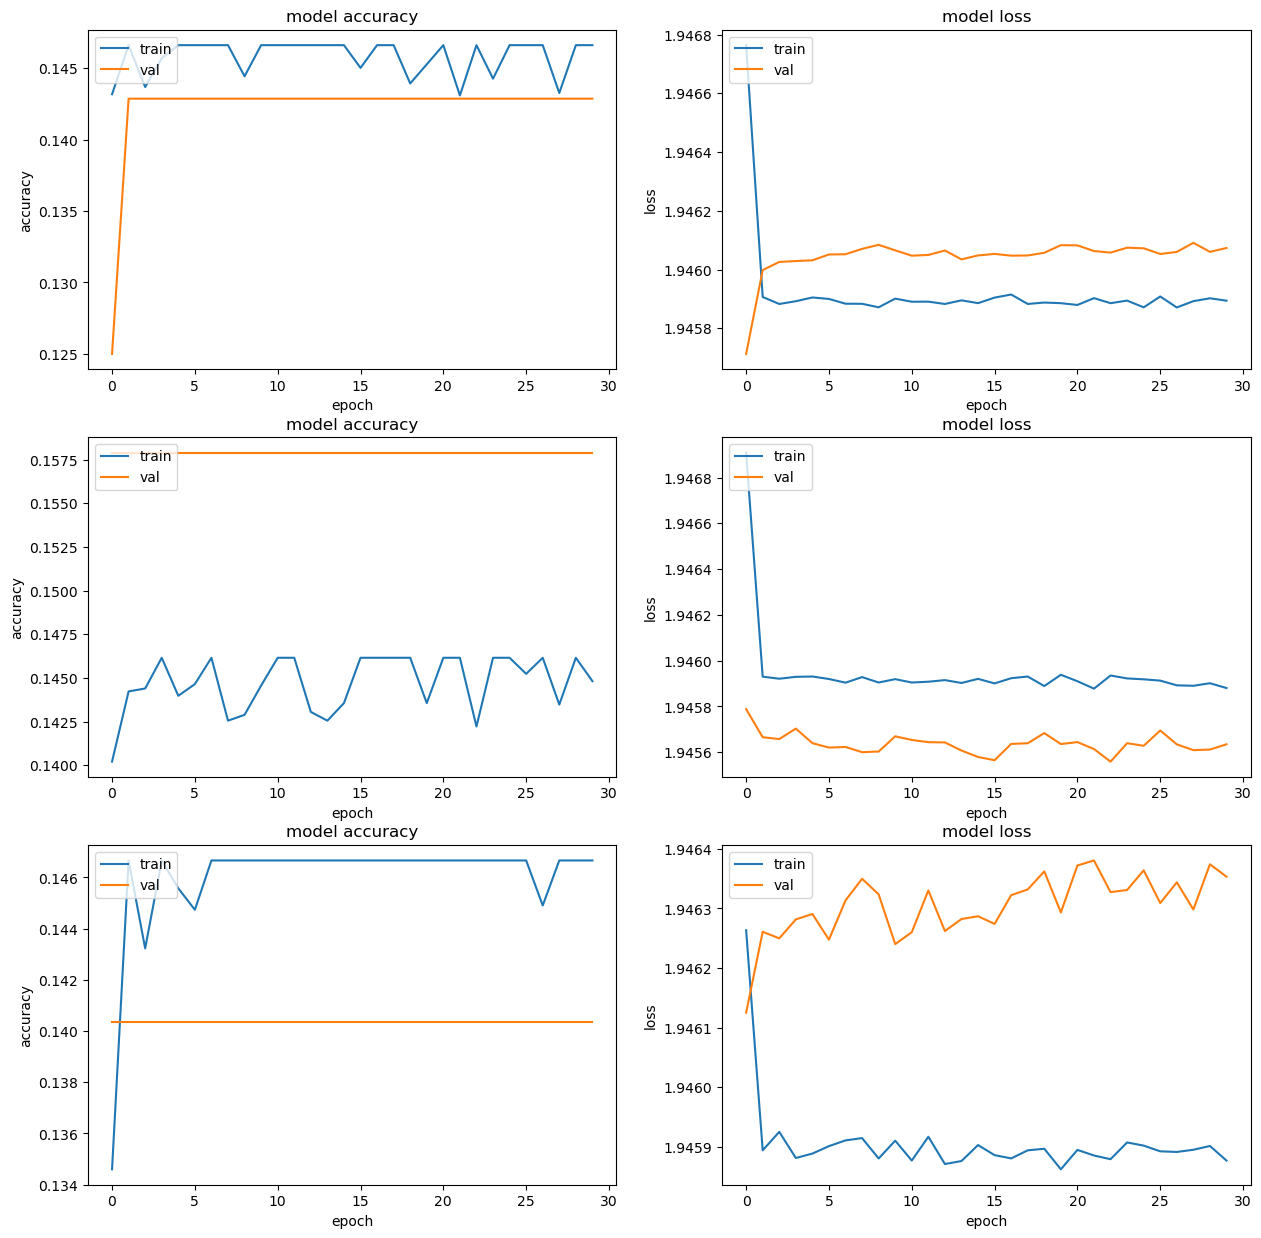

In [22]:
plot_stats(ac3_5)

In [23]:
ac3_6 = train_avaluate(get_m6, kf3, data["ravdess"]["x"], data["ravdess"]["y"] )

Epoch 1/30
187/187 [==============================] - 16s 74ms/step - loss: 1.9527 - accuracy: 0.1486 - val_loss: 1.9459 - val_accuracy: 0.1429
Epoch 2/30
187/187 [==============================] - 13s 71ms/step - loss: 1.9459 - accuracy: 0.1533 - val_loss: 1.9460 - val_accuracy: 0.1429
Epoch 3/30
187/187 [==============================] - 13s 71ms/step - loss: 1.9459 - accuracy: 0.1455 - val_loss: 1.9460 - val_accuracy: 0.1429
Epoch 4/30
187/187 [==============================] - 13s 71ms/step - loss: 1.9460 - accuracy: 0.1457 - val_loss: 1.9460 - val_accuracy: 0.1429
Epoch 5/30
187/187 [==============================] - 13s 72ms/step - loss: 1.9460 - accuracy: 0.1407 - val_loss: 1.9461 - val_accuracy: 0.1429
Epoch 6/30
187/187 [==============================] - 13s 71ms/step - loss: 1.9458 - accuracy: 0.1514 - val_loss: 1.9461 - val_accuracy: 0.1429
Epoch 7/30
187/187 [==============================] - 13s 71ms/step - loss: 1.9461 - accuracy: 0.1392 - val_loss: 1.9461 - val_accuracy:

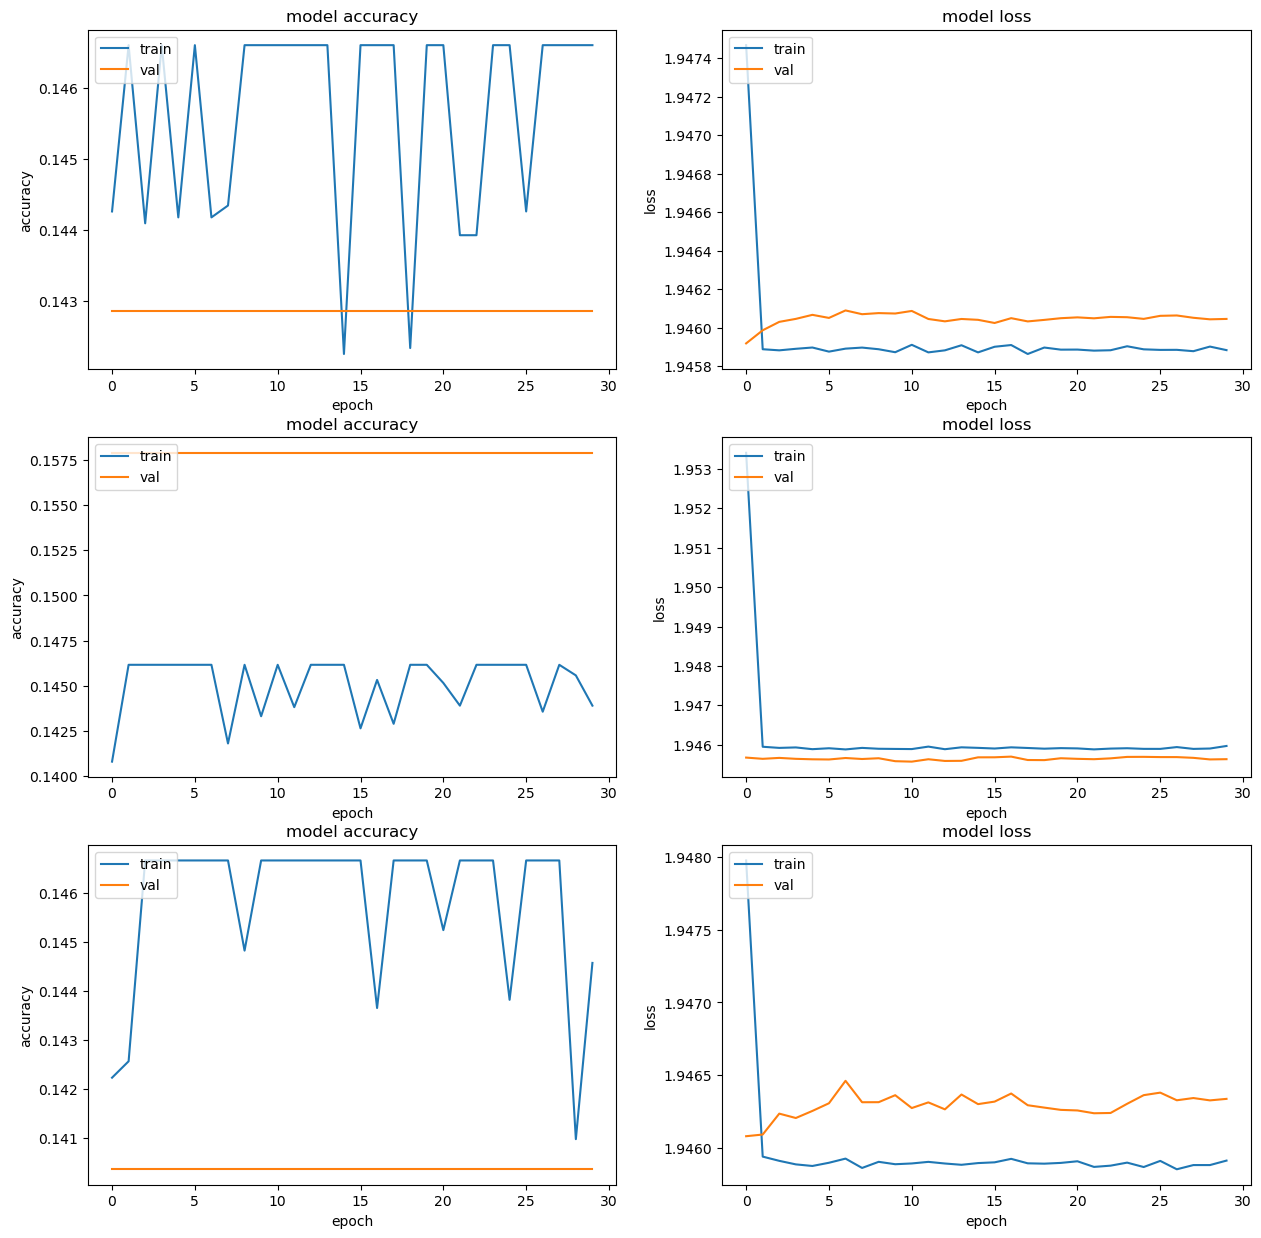

In [24]:
plot_stats(ac3_6)